# Aggregate Visualizations: All Models Combined

This notebook creates the same visualizations as the model-specific visualization module, but aggregated across all evaluated models. This allows for:
- Cross-model comparison of bias transfer patterns
- Identification of universal vs model-specific patterns
- Overall trends across the entire evaluation dataset

**Note:** This notebook also exports summary tables and statistics alongside the visualizations.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# For displaying DataFrames in notebook
try:
    from IPython.display import display
except ImportError:
    # Fallback if not in Jupyter - just print the DataFrame
    def display(obj):
        if isinstance(obj, pd.DataFrame):
            print(obj.to_string())
        else:
            print(obj)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Configuration
RESULTS_DIR = Path('../drift_analysis/results')
OUTPUT_DIR = Path('./results/aggregate_visualizations')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Results directory: {RESULTS_DIR}")
print(f"Output directory: {OUTPUT_DIR}")


Results directory: ..\drift_analysis\results
Output directory: results\aggregate_visualizations


## 1. Load All Model Data


In [10]:
def load_all_model_data(results_dir: Path, date: str = None) -> pd.DataFrame:
    """Load detailed drift_analysis.csv files from all models."""
    all_results = []
    
    # Find date if not specified
    if date is None:
        dates = set()
        for model_dir in results_dir.iterdir():
            if model_dir.is_dir() and not model_dir.name.startswith('.'):
                for date_dir in model_dir.iterdir():
                    if date_dir.is_dir() and date_dir.name.isdigit():
                        dates.add(date_dir.name)
        if dates:
            date = max(dates)
            print(f"Using latest date: {date}")
        else:
            print("No results found!")
            return pd.DataFrame()
    
    # Load detailed results
    for model_dir in results_dir.iterdir():
        if model_dir.is_dir() and not model_dir.name.startswith('.'):
            detail_file = model_dir / date / 'drift_analysis.csv'
            if detail_file.exists():
                try:
                    df = pd.read_csv(detail_file)
                    all_results.append(df)
                    print(f"✓ Loaded: {model_dir.name} ({len(df)} entries)")
                except Exception as e:
                    print(f"✗ Error loading {model_dir.name}: {e}")
    
    if not all_results:
        return pd.DataFrame()
    
    combined = pd.concat(all_results, ignore_index=True)
    print(f"\nTotal entries loaded: {len(combined):,}")
    return combined

# Load all data
print("Loading data from all models...")
df_all = load_all_model_data(RESULTS_DIR)

# Filter valid entries (with HEARTS scores)
if not df_all.empty:
    valid_df = df_all[df_all['drift_drift_score'].notna()].copy()
    print(f"Valid entries: {len(valid_df):,}")
    print(f"Models: {valid_df['model_id'].nunique()}")
    print(f"Bias types: {valid_df['bias_type'].nunique() if 'bias_type' in valid_df.columns else 0}")
    print(f"Stereotype types: {valid_df['emgsd_stereotype_type'].nunique() if 'emgsd_stereotype_type' in valid_df.columns else 0}")
    valid_df.head()


Loading data from all models...
Using latest date: 20251210
✓ Loaded: deepseek-llm_7b (800 entries)
✓ Loaded: gemma2_9b (800 entries)
✓ Loaded: llama3_1_8b (800 entries)
✓ Loaded: llama3_2_1b (800 entries)
✓ Loaded: llama3_2_3b (800 entries)
✓ Loaded: mistral_7b (800 entries)
✓ Loaded: qwen2_5_7b (800 entries)
✓ Loaded: us_amazon_nova-lite-v1_0 (800 entries)
✓ Loaded: us_amazon_nova-micro-v1_0 (800 entries)
✓ Loaded: us_amazon_nova-pro-v1_0 (800 entries)
✓ Loaded: us_anthropic_claude-3-5-haiku-20241022-v1_0 (800 entries)
✓ Loaded: us_anthropic_claude-3-haiku-20240307-v1_0 (800 entries)
✓ Loaded: us_meta_llama3-1-70b-instruct-v1_0 (800 entries)

Total entries loaded: 10,400
Valid entries: 9,600
Models: 12
Bias types: 8
Stereotype types: 4


## 2. Drift Distribution (Aggregated)


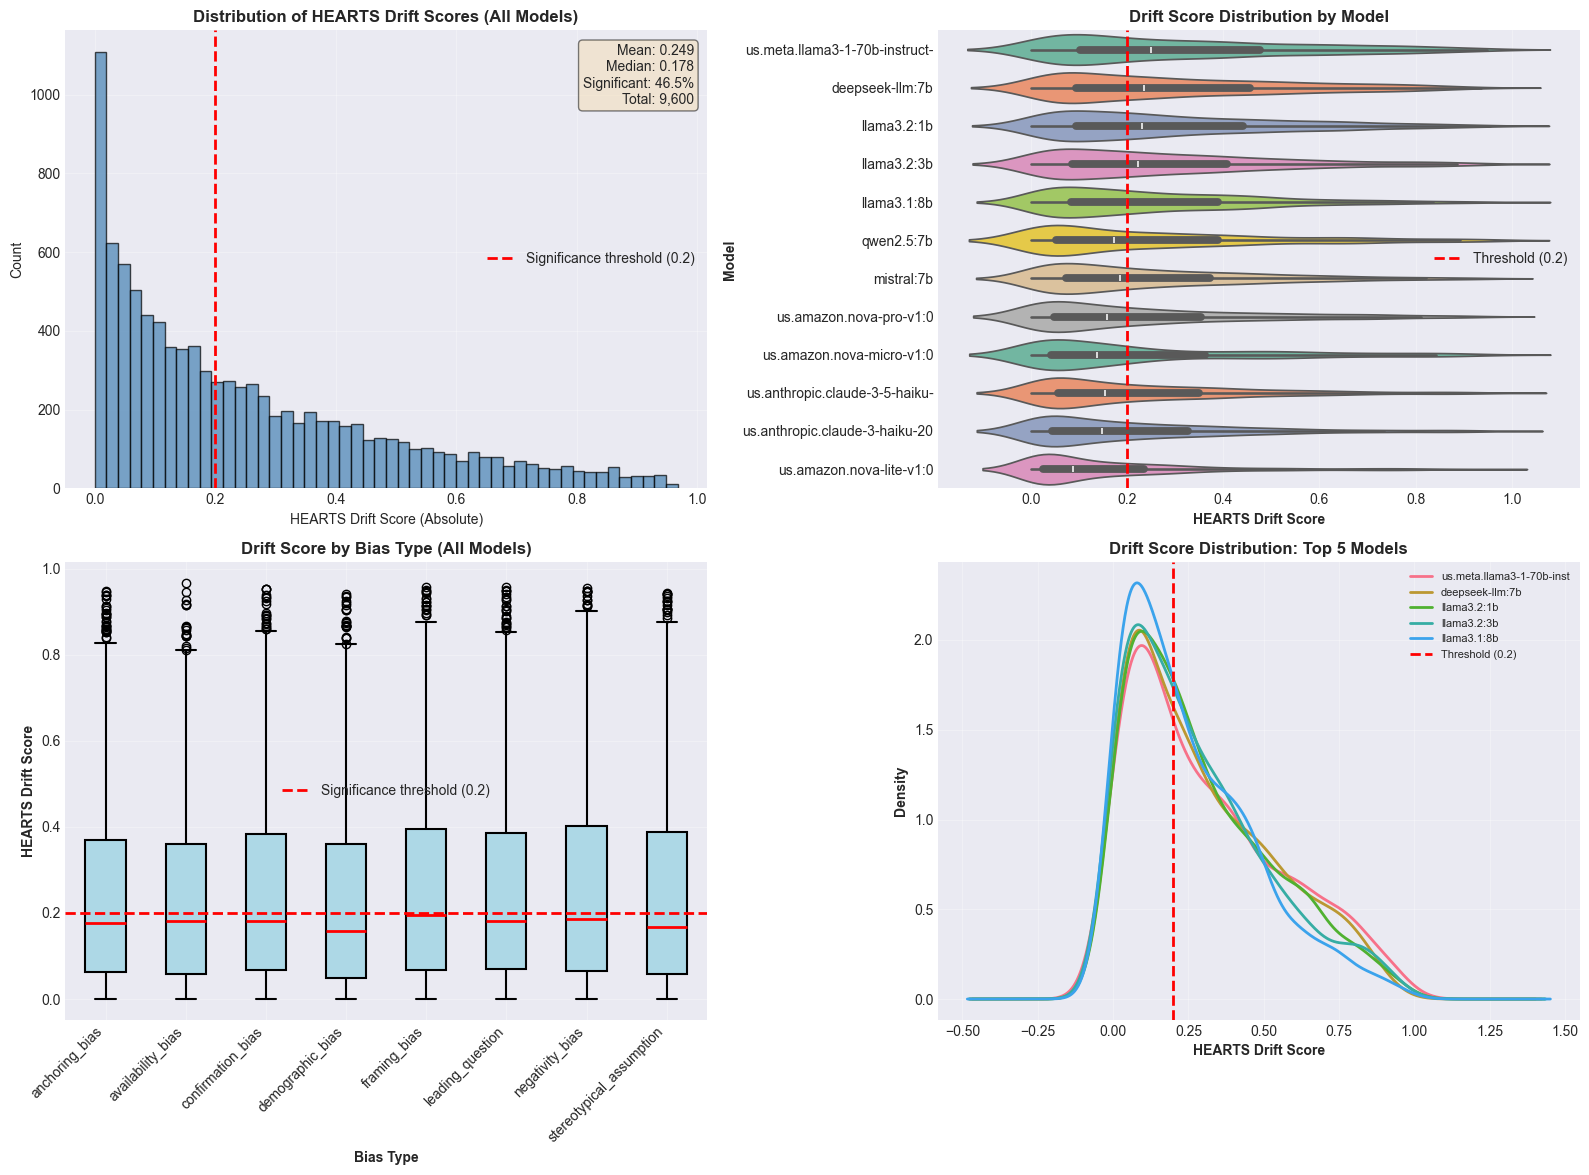

✓ Saved: results\aggregate_visualizations\drift_distribution.png


In [31]:
def visualize_aggregate_drift_distribution(df: pd.DataFrame, output_dir: Path):
    """Generate aggregate drift score distribution visualization."""
    if df.empty or 'drift_drift_score' not in df.columns:
        print("WARNING: HEARTS drift scores not available")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Overall distribution histogram
    axes[0, 0].hist(df['drift_drift_score'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    axes[0, 0].axvline(0.2, color='red', linestyle='--', linewidth=2, label='Significance threshold (0.2)')
    axes[0, 0].set_xlabel('HEARTS Drift Score (Absolute)')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].set_title('Distribution of HEARTS Drift Scores (All Models)', fontweight='bold', fontsize=12)
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Add statistics
    mean_drift = df['drift_drift_score'].mean()
    median_drift = df['drift_drift_score'].median()
    significant_rate = df['drift_significant_drift'].mean() if 'drift_significant_drift' in df.columns else 0
    stats_text = f"Mean: {mean_drift:.3f}\nMedian: {median_drift:.3f}\nSignificant: {significant_rate:.1%}\nTotal: {len(df):,}"
    axes[0, 0].text(0.98, 0.97, stats_text, transform=axes[0, 0].transAxes,
                    verticalalignment='top', horizontalalignment='right',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                    fontsize=10)
    
    # 2. Distribution by model (violin plot)
    if 'model_id' in df.columns:
        model_order = df.groupby('model_id')['drift_drift_score'].mean().sort_values(ascending=False).index
        df_plot = df.copy()
        df_plot['model_short'] = df_plot['model_id'].str.replace('us_', '').str.replace('_', ' ').str[:30]
        
        sns.violinplot(data=df_plot, y='model_short', x='drift_drift_score',
                      order=[m.replace('us_', '').replace('_', ' ')[:30] for m in model_order],
                      ax=axes[0, 1], palette='Set2', inner='box')
        axes[0, 1].axvline(0.2, color='red', linestyle='--', linewidth=2, label='Threshold (0.2)')
        axes[0, 1].set_xlabel('HEARTS Drift Score', fontweight='bold')
        axes[0, 1].set_ylabel('Model', fontweight='bold')
        axes[0, 1].set_title('Drift Score Distribution by Model', fontweight='bold', fontsize=12)
        axes[0, 1].legend()
        axes[0, 1].grid(alpha=0.3, axis='x')
    
    # 3. Box plot by bias type (aggregated)
    if 'bias_type' in df.columns:
        bias_order = df.groupby('bias_type')['drift_drift_score'].mean().sort_values(ascending=False).index
        bp = df.boxplot(column='drift_drift_score', by='bias_type', ax=axes[1, 0], patch_artist=True, return_type='dict')
        # Color the box plots - iterate through all box elements
        for box in bp['drift_drift_score']['boxes']:
            box.set_facecolor('lightblue')
            box.set_edgecolor('black')
            box.set_linewidth(1.5)
        for whisker in bp['drift_drift_score']['whiskers']:
            whisker.set_color('black')
            whisker.set_linewidth(1.5)
        for cap in bp['drift_drift_score']['caps']:
            cap.set_color('black')
            cap.set_linewidth(1.5)
        for median in bp['drift_drift_score']['medians']:
            median.set_color('red')
            median.set_linewidth(2)
        axes[1, 0].axhline(0.2, color='red', linestyle='--', linewidth=2, label='Significance threshold (0.2)')
        axes[1, 0].set_xlabel('Bias Type', fontweight='bold')
        axes[1, 0].set_ylabel('HEARTS Drift Score', fontweight='bold')
        axes[1, 0].set_title('Drift Score by Bias Type (All Models)', fontweight='bold', fontsize=12)
        axes[1, 0].get_figure().suptitle('')
        plt.setp(axes[1, 0].xaxis.get_majorticklabels(), rotation=45, ha='right')
        axes[1, 0].legend()
        axes[1, 0].grid(alpha=0.3)
    
    # 4. KDE plot comparison by model (sample of top models)
    if 'model_id' in df.columns:
        top_models = df.groupby('model_id')['drift_drift_score'].mean().nlargest(5).index
        for model in top_models:
            model_data = df[df['model_id'] == model]['drift_drift_score']
            model_data.plot(kind='kde', ax=axes[1, 1], label=model.replace('us_', '').replace('_', ' ')[:25], linewidth=2)
        axes[1, 1].axvline(0.2, color='red', linestyle='--', linewidth=2, label='Threshold (0.2)')
        axes[1, 1].set_xlabel('HEARTS Drift Score', fontweight='bold')
        axes[1, 1].set_ylabel('Density', fontweight='bold')
        axes[1, 1].set_title('Drift Score Distribution: Top 5 Models', fontweight='bold', fontsize=12)
        axes[1, 1].legend(fontsize=8)
        axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    output_file = output_dir / 'drift_distribution.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"✓ Saved: {output_file}")

if not valid_df.empty:
    visualize_aggregate_drift_distribution(valid_df, OUTPUT_DIR)

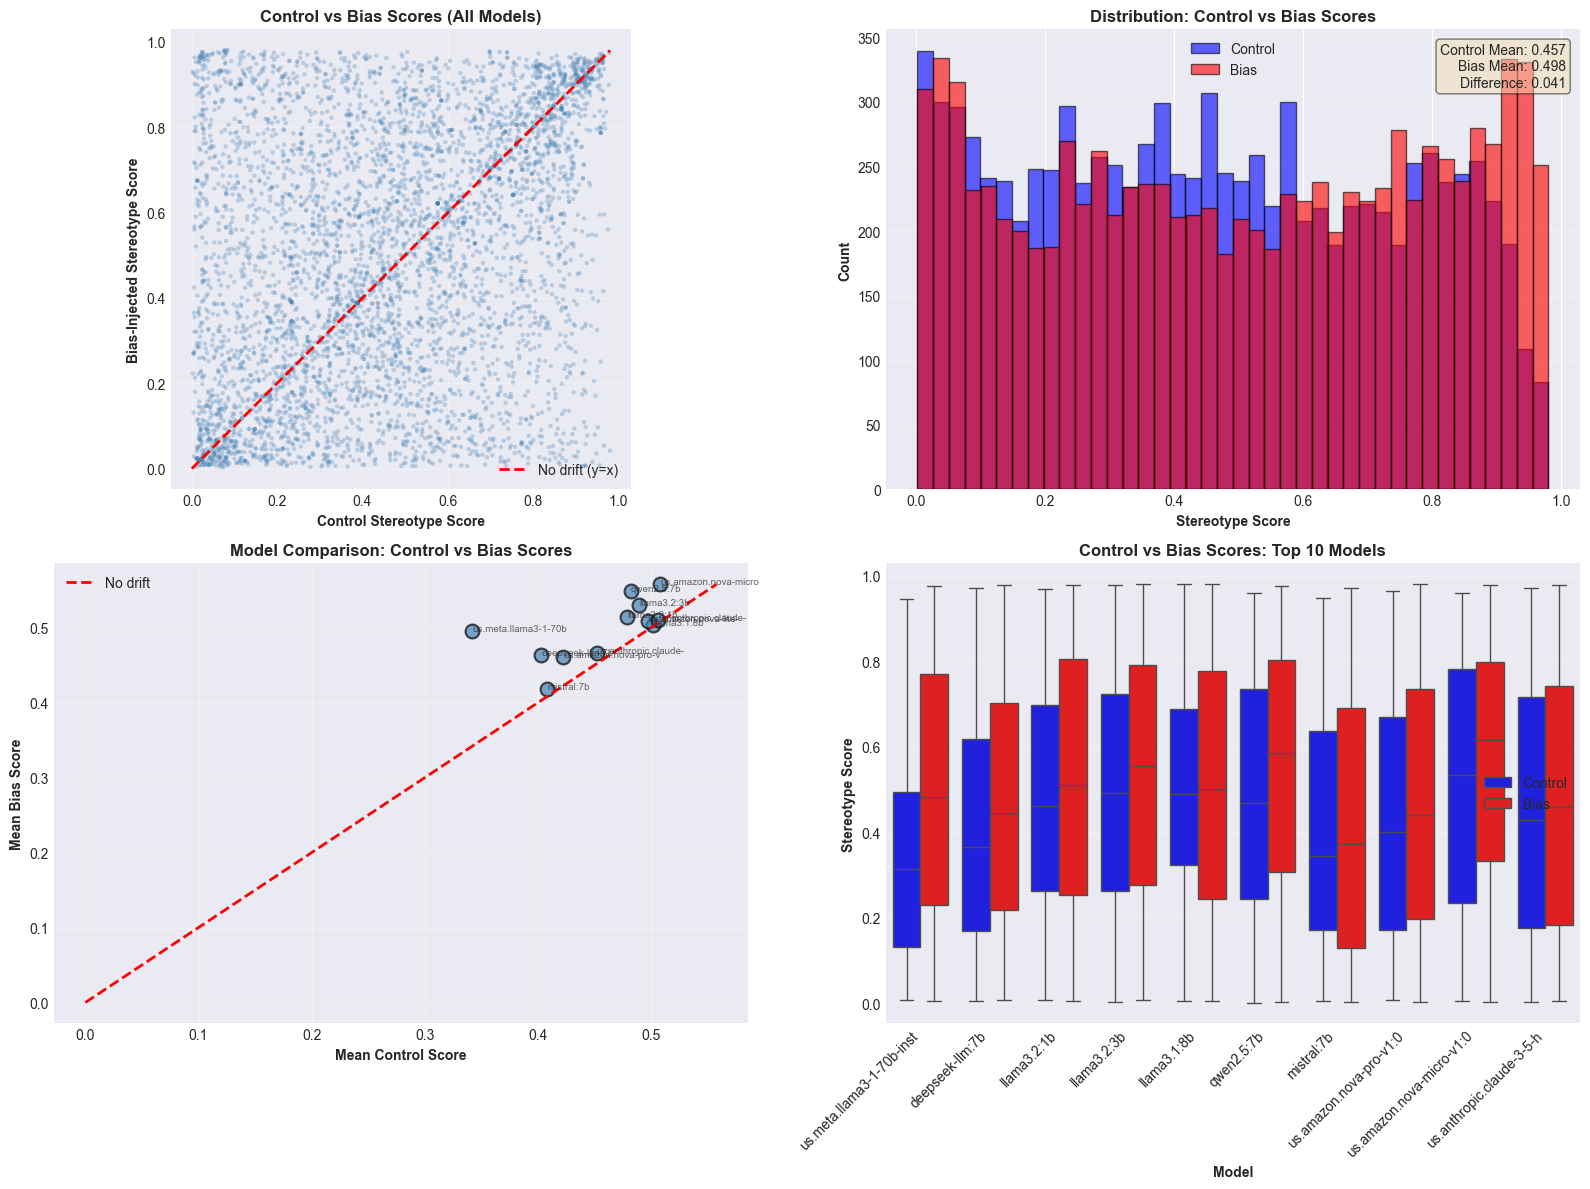

✓ Saved: results\aggregate_visualizations\control_vs_bias_comparison.png


In [12]:
def visualize_aggregate_control_vs_bias(df: pd.DataFrame, output_dir: Path):
    """Generate aggregate control vs bias-injected comparison visualization."""
    if 'drift_control_stereotype_score' not in df.columns or 'drift_bias_stereotype_score' not in df.columns:
        print("WARNING: Control/bias stereotype scores not available")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Scatter plot: Control vs Bias (all models, sampled if too large)
    sample_df = df.sample(min(5000, len(df))) if len(df) > 5000 else df
    axes[0, 0].scatter(sample_df['drift_control_stereotype_score'], 
                      sample_df['drift_bias_stereotype_score'],
                      alpha=0.3, s=10, c='steelblue', edgecolors='none')
    max_val = max(sample_df['drift_control_stereotype_score'].max(),
                 sample_df['drift_bias_stereotype_score'].max())
    axes[0, 0].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='No drift (y=x)')
    axes[0, 0].set_xlabel('Control Stereotype Score', fontweight='bold')
    axes[0, 0].set_ylabel('Bias-Injected Stereotype Score', fontweight='bold')
    axes[0, 0].set_title('Control vs Bias Scores (All Models)', fontweight='bold', fontsize=12)
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    axes[0, 0].set_aspect('equal', adjustable='box')
    
    # 2. Histogram comparison: Control vs Bias distributions
    axes[0, 1].hist(df['drift_control_stereotype_score'], bins=40, alpha=0.6, 
                   color='blue', label='Control', edgecolor='black')
    axes[0, 1].hist(df['drift_bias_stereotype_score'], bins=40, alpha=0.6, 
                   color='red', label='Bias', edgecolor='black')
    axes[0, 1].set_xlabel('Stereotype Score', fontweight='bold')
    axes[0, 1].set_ylabel('Count', fontweight='bold')
    axes[0, 1].set_title('Distribution: Control vs Bias Scores', fontweight='bold', fontsize=12)
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3, axis='y')
    
    # Add statistics
    control_mean = df['drift_control_stereotype_score'].mean()
    bias_mean = df['drift_bias_stereotype_score'].mean()
    stats_text = f"Control Mean: {control_mean:.3f}\nBias Mean: {bias_mean:.3f}\nDifference: {bias_mean - control_mean:.3f}"
    axes[0, 1].text(0.98, 0.97, stats_text, transform=axes[0, 1].transAxes,
                    verticalalignment='top', horizontalalignment='right',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                    fontsize=10)
    
    # 3. Model comparison: Mean control vs bias scores
    if 'model_id' in df.columns:
        model_stats = df.groupby('model_id').agg({
            'drift_control_stereotype_score': 'mean',
            'drift_bias_stereotype_score': 'mean'
        }).reset_index()
        
        axes[1, 0].scatter(model_stats['drift_control_stereotype_score'], 
                          model_stats['drift_bias_stereotype_score'],
                          s=100, alpha=0.7, edgecolors='black', linewidth=1.5, c='steelblue')
        
        # Add model labels
        for idx, row in model_stats.iterrows():
            model_name = row['model_id'].replace('us_', '').replace('_', ' ')[:20]
            axes[1, 0].annotate(model_name, 
                               (row['drift_control_stereotype_score'], row['drift_bias_stereotype_score']),
                               fontsize=7, alpha=0.7)
        
        max_val = max(model_stats['drift_control_stereotype_score'].max(),
                     model_stats['drift_bias_stereotype_score'].max())
        axes[1, 0].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='No drift')
        axes[1, 0].set_xlabel('Mean Control Score', fontweight='bold')
        axes[1, 0].set_ylabel('Mean Bias Score', fontweight='bold')
        axes[1, 0].set_title('Model Comparison: Control vs Bias Scores', fontweight='bold', fontsize=12)
        axes[1, 0].legend()
        axes[1, 0].grid(alpha=0.3)
    
    # 4. Box plot: Control vs Bias by model (top 10)
    if 'model_id' in df.columns:
        top_models = df.groupby('model_id')['drift_drift_score'].mean().nlargest(10).index
        df_top = df[df['model_id'].isin(top_models)].copy()
        df_top['model_short'] = df_top['model_id'].str.replace('us_', '').str.replace('_', ' ').str[:25]
        
        # Prepare data for boxplot
        plot_data = []
        for model in top_models:
            model_data = df_top[df_top['model_id'] == model]
            plot_data.extend([
                {'Model': model.replace('us_', '').replace('_', ' ')[:25], 'Score': score, 'Type': 'Control'}
                for score in model_data['drift_control_stereotype_score'].values
            ])
            plot_data.extend([
                {'Model': model.replace('us_', '').replace('_', ' ')[:25], 'Score': score, 'Type': 'Bias'}
                for score in model_data['drift_bias_stereotype_score'].values
            ])
        
        plot_df = pd.DataFrame(plot_data)
        sns.boxplot(data=plot_df, x='Model', y='Score', hue='Type', ax=axes[1, 1], palette=['blue', 'red'])
        axes[1, 1].set_xlabel('Model', fontweight='bold')
        axes[1, 1].set_ylabel('Stereotype Score', fontweight='bold')
        axes[1, 1].set_title('Control vs Bias Scores: Top 10 Models', fontweight='bold', fontsize=12)
        plt.setp(axes[1, 1].xaxis.get_majorticklabels(), rotation=45, ha='right')
        axes[1, 1].legend()
        axes[1, 1].grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    output_file = output_dir / 'control_vs_bias_comparison.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"✓ Saved: {output_file}")

if not valid_df.empty:
    visualize_aggregate_control_vs_bias(valid_df, OUTPUT_DIR)


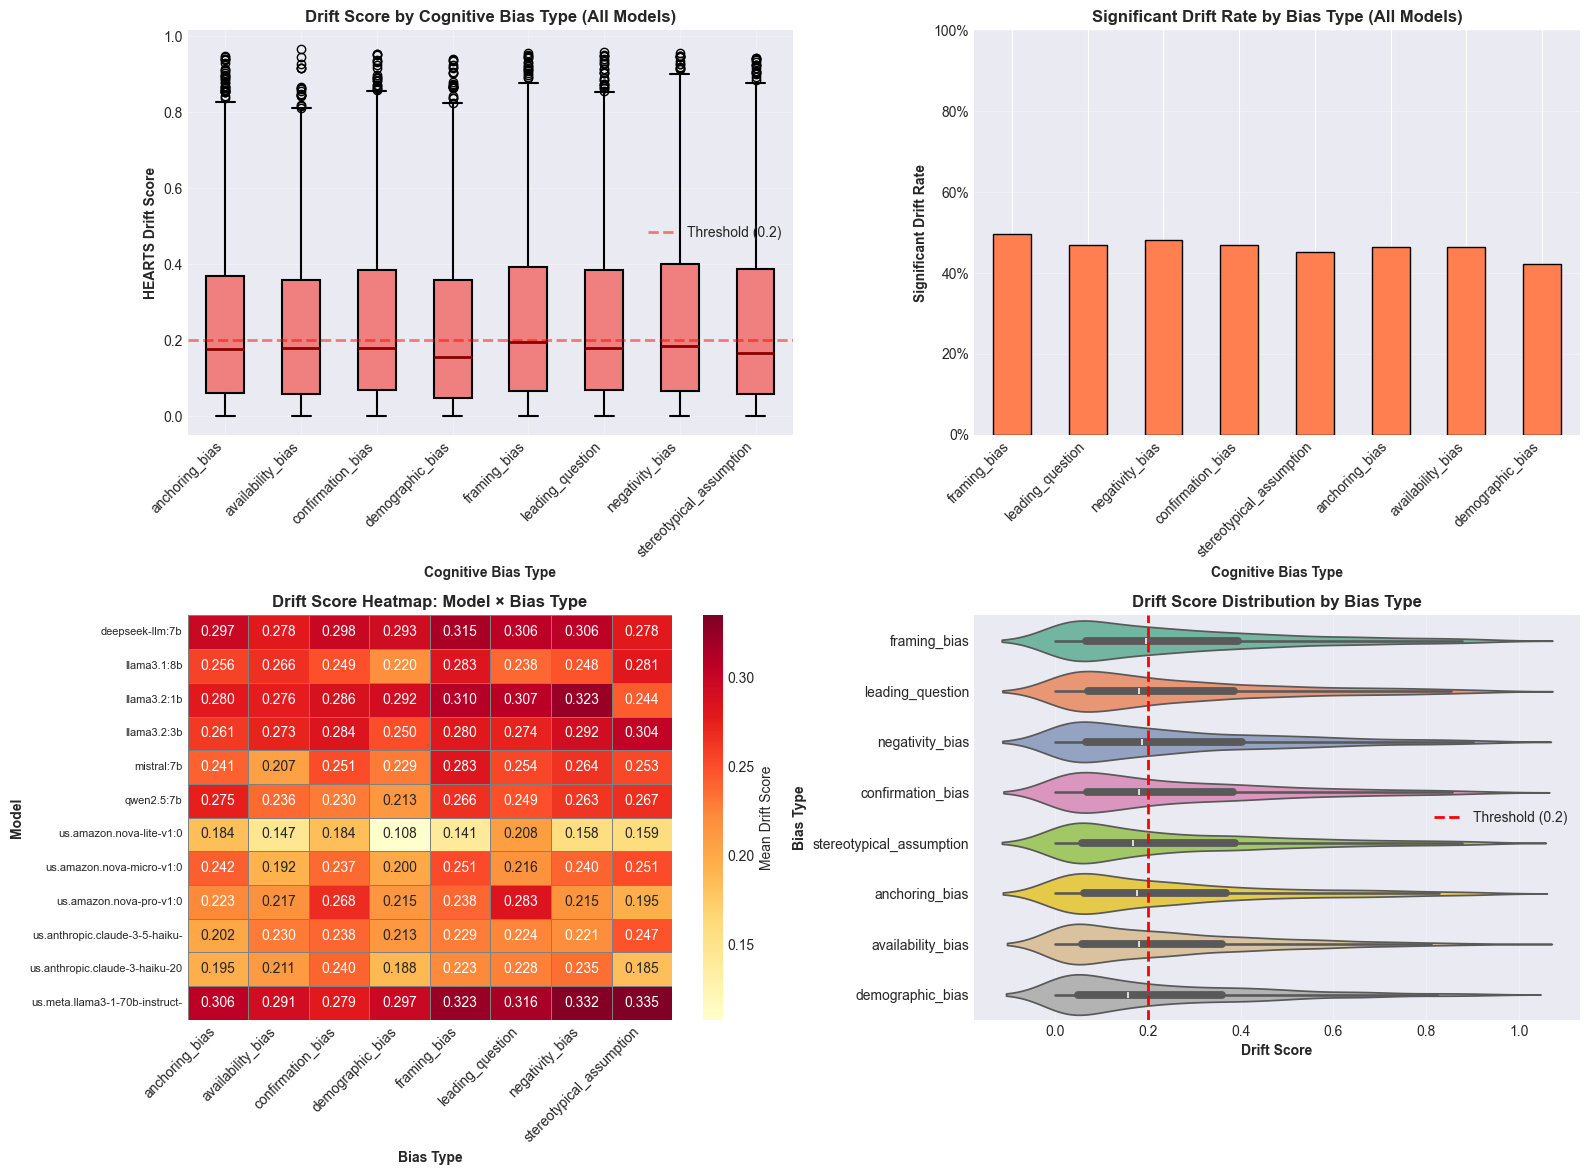

✓ Saved: results\aggregate_visualizations\drift_by_bias_type.png


In [20]:
def visualize_aggregate_drift_by_bias_type(df: pd.DataFrame, output_dir: Path):
    """Generate aggregate drift by bias type visualization."""
    if 'bias_type' not in df.columns or 'drift_drift_score' not in df.columns:
        print("WARNING: Bias type information not available")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Box plot by bias type (aggregated)
    bias_order = df.groupby('bias_type')['drift_drift_score'].mean().sort_values(ascending=False).index
    bp = df.boxplot(column='drift_drift_score', by='bias_type', ax=axes[0, 0], patch_artist=True, return_type='dict')
    # Color the box plots - iterate through all box elements
    for box in bp['drift_drift_score']['boxes']:
        box.set_facecolor('lightcoral')
        box.set_edgecolor('black')
        box.set_linewidth(1.5)
    for whisker in bp['drift_drift_score']['whiskers']:
        whisker.set_color('black')
        whisker.set_linewidth(1.5)
    for cap in bp['drift_drift_score']['caps']:
        cap.set_color('black')
        cap.set_linewidth(1.5)
    for median in bp['drift_drift_score']['medians']:
        median.set_color('darkred')
        median.set_linewidth(2)
    axes[0, 0].axhline(0.2, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Threshold (0.2)')
    axes[0, 0].set_xlabel('Cognitive Bias Type', fontweight='bold')
    axes[0, 0].set_ylabel('HEARTS Drift Score', fontweight='bold')
    axes[0, 0].set_title('Drift Score by Cognitive Bias Type (All Models)', fontweight='bold', fontsize=12)
    axes[0, 0].get_figure().suptitle('')
    plt.setp(axes[0, 0].xaxis.get_majorticklabels(), rotation=45, ha='right')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # 2. Bar plot: Significant drift rate by bias type
    if 'drift_significant_drift' in df.columns:
        bias_type_stats = df.groupby('bias_type').agg({
            'drift_significant_drift': 'mean',
            'drift_drift_score': 'mean'
        }).sort_values('drift_drift_score', ascending=False)
        
        bias_type_stats['drift_significant_drift'].plot(kind='bar', ax=axes[0, 1], 
                                                        color='coral', edgecolor='black')
        axes[0, 1].set_xlabel('Cognitive Bias Type', fontweight='bold')
        axes[0, 1].set_ylabel('Significant Drift Rate', fontweight='bold')
        axes[0, 1].set_title('Significant Drift Rate by Bias Type (All Models)', fontweight='bold', fontsize=12)
        axes[0, 1].set_ylim(0, 1)
        axes[0, 1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
        plt.setp(axes[0, 1].xaxis.get_majorticklabels(), rotation=45, ha='right')
        axes[0, 1].grid(alpha=0.3, axis='y')
    
    # 3. Heatmap: Model x Bias Type
    if 'model_id' in df.columns:
        pivot = df.pivot_table(values='drift_drift_score', 
                              index='model_id', 
                              columns='bias_type', 
                              aggfunc='mean')
        # Shorten model names
        pivot.index = [m.replace('us_', '').replace('_', ' ')[:30] for m in pivot.index]
        
        sns.heatmap(pivot, annot=True, fmt='.3f', cmap='YlOrRd', 
                    ax=axes[1, 0], cbar_kws={'label': 'Mean Drift Score'}, 
                    linewidths=0.5, linecolor='gray')
        axes[1, 0].set_title('Drift Score Heatmap: Model × Bias Type', fontweight='bold', fontsize=12)
        axes[1, 0].set_xlabel('Bias Type', fontweight='bold')
        axes[1, 0].set_ylabel('Model', fontweight='bold')
        plt.setp(axes[1, 0].get_xticklabels(), rotation=45, ha='right')
        plt.setp(axes[1, 0].get_yticklabels(), rotation=0, fontsize=8)
    
    # 4. Violin plot: Distribution by bias type
    sns.violinplot(data=df, y='bias_type', x='drift_drift_score', 
                  order=bias_order, ax=axes[1, 1], palette='Set2', inner='box')
    axes[1, 1].axvline(0.2, color='red', linestyle='--', linewidth=2, label='Threshold (0.2)')
    axes[1, 1].set_xlabel('Drift Score', fontweight='bold')
    axes[1, 1].set_ylabel('Bias Type', fontweight='bold')
    axes[1, 1].set_title('Drift Score Distribution by Bias Type', fontweight='bold', fontsize=12)
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3, axis='x')
    
    plt.tight_layout()
    output_file = output_dir / 'drift_by_bias_type.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"✓ Saved: {output_file}")

if not valid_df.empty:
    visualize_aggregate_drift_by_bias_type(valid_df, OUTPUT_DIR)

## 5. Drift by Stereotype Type (Aggregated)


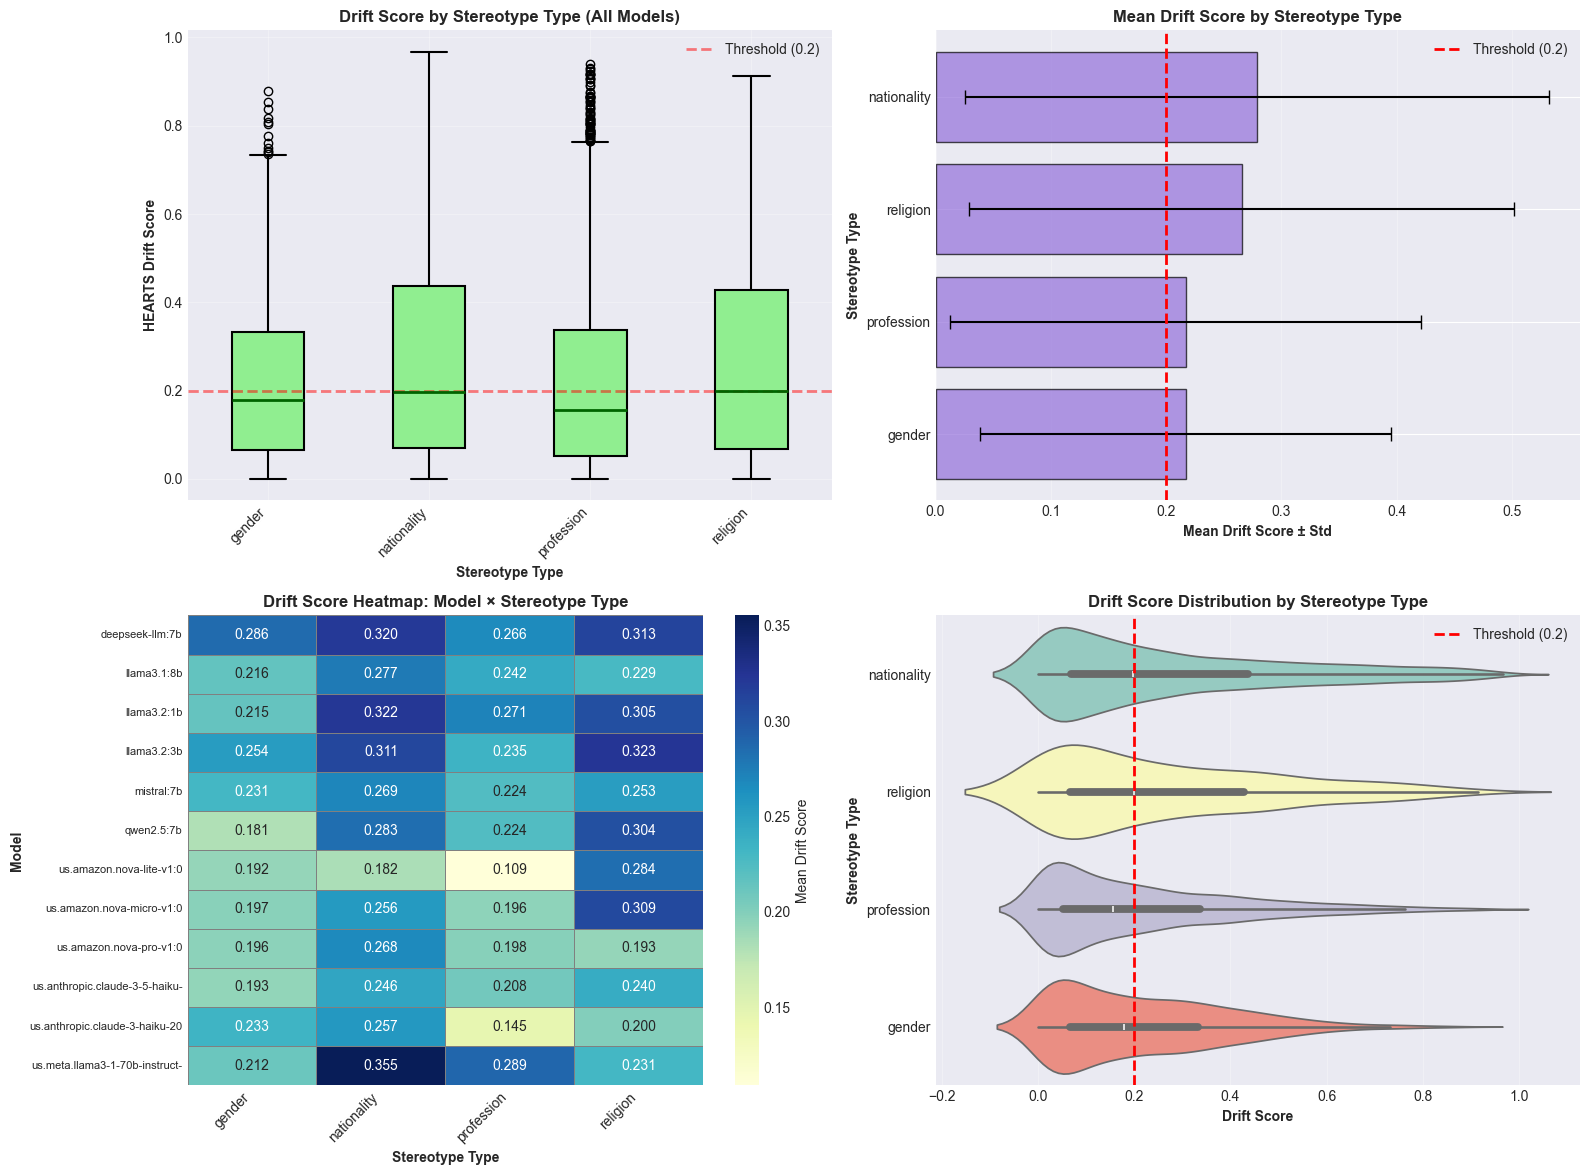

✓ Saved: results\aggregate_visualizations\drift_by_stereotype_type.png


In [19]:
def visualize_aggregate_drift_by_stereotype_type(df: pd.DataFrame, output_dir: Path):
    """Generate aggregate drift by stereotype type visualization."""
    if 'emgsd_stereotype_type' not in df.columns or 'drift_drift_score' not in df.columns:
        print("WARNING: Stereotype type information not available")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Box plot by stereotype type
    stereo_order = df.groupby('emgsd_stereotype_type')['drift_drift_score'].mean().sort_values(ascending=False).index
    bp = df.boxplot(column='drift_drift_score', by='emgsd_stereotype_type', ax=axes[0, 0], patch_artist=True, return_type='dict')
    # Color the box plots - iterate through all box elements
    for box in bp['drift_drift_score']['boxes']:
        box.set_facecolor('lightgreen')
        box.set_edgecolor('black')
        box.set_linewidth(1.5)
    for whisker in bp['drift_drift_score']['whiskers']:
        whisker.set_color('black')
        whisker.set_linewidth(1.5)
    for cap in bp['drift_drift_score']['caps']:
        cap.set_color('black')
        cap.set_linewidth(1.5)
    for median in bp['drift_drift_score']['medians']:
        median.set_color('darkgreen')
        median.set_linewidth(2)
    axes[0, 0].axhline(0.2, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Threshold (0.2)')
    axes[0, 0].set_xlabel('Stereotype Type', fontweight='bold')
    axes[0, 0].set_ylabel('HEARTS Drift Score', fontweight='bold')
    axes[0, 0].set_title('Drift Score by Stereotype Type (All Models)', fontweight='bold', fontsize=12)
    axes[0, 0].get_figure().suptitle('')
    plt.setp(axes[0, 0].xaxis.get_majorticklabels(), rotation=45, ha='right')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # 2. Bar plot: Mean drift by stereotype type
    stereo_stats = df.groupby('emgsd_stereotype_type')['drift_drift_score'].agg(['mean', 'std']).reset_index()
    stereo_stats = stereo_stats.sort_values('mean', ascending=True)
    
    y_pos = np.arange(len(stereo_stats))
    bars = axes[0, 1].barh(y_pos, stereo_stats['mean'], 
                           xerr=stereo_stats['std'], 
                           color='mediumpurple', edgecolor='black', alpha=0.7, capsize=5)
    axes[0, 1].set_yticks(y_pos)
    axes[0, 1].set_yticklabels(stereo_stats['emgsd_stereotype_type'])
    axes[0, 1].set_xlabel('Mean Drift Score ± Std', fontweight='bold')
    axes[0, 1].set_ylabel('Stereotype Type', fontweight='bold')
    axes[0, 1].set_title('Mean Drift Score by Stereotype Type', fontweight='bold', fontsize=12)
    axes[0, 1].axvline(0.2, color='red', linestyle='--', linewidth=2, label='Threshold (0.2)')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3, axis='x')
    
    # 3. Heatmap: Model x Stereotype Type
    if 'model_id' in df.columns:
        pivot = df.pivot_table(values='drift_drift_score', 
                              index='model_id', 
                              columns='emgsd_stereotype_type', 
                              aggfunc='mean')
        pivot.index = [m.replace('us_', '').replace('_', ' ')[:30] for m in pivot.index]
        
        sns.heatmap(pivot, annot=True, fmt='.3f', cmap='YlGnBu', 
                    ax=axes[1, 0], cbar_kws={'label': 'Mean Drift Score'}, 
                    linewidths=0.5, linecolor='gray')
        axes[1, 0].set_title('Drift Score Heatmap: Model × Stereotype Type', fontweight='bold', fontsize=12)
        axes[1, 0].set_xlabel('Stereotype Type', fontweight='bold')
        axes[1, 0].set_ylabel('Model', fontweight='bold')
        plt.setp(axes[1, 0].get_xticklabels(), rotation=45, ha='right')
        plt.setp(axes[1, 0].get_yticklabels(), rotation=0, fontsize=8)
    
    # 4. Violin plot: Distribution by stereotype type
    sns.violinplot(data=df, y='emgsd_stereotype_type', x='drift_drift_score', 
                  order=stereo_order, ax=axes[1, 1], palette='Set3', inner='box')
    axes[1, 1].axvline(0.2, color='red', linestyle='--', linewidth=2, label='Threshold (0.2)')
    axes[1, 1].set_xlabel('Drift Score', fontweight='bold')
    axes[1, 1].set_ylabel('Stereotype Type', fontweight='bold')
    axes[1, 1].set_title('Drift Score Distribution by Stereotype Type', fontweight='bold', fontsize=12)
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3, axis='x')
    
    plt.tight_layout()
    output_file = output_dir / 'drift_by_stereotype_type.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"✓ Saved: {output_file}")

if not valid_df.empty:
    visualize_aggregate_drift_by_stereotype_type(valid_df, OUTPUT_DIR)

## 6. Heatmaps (Aggregated)


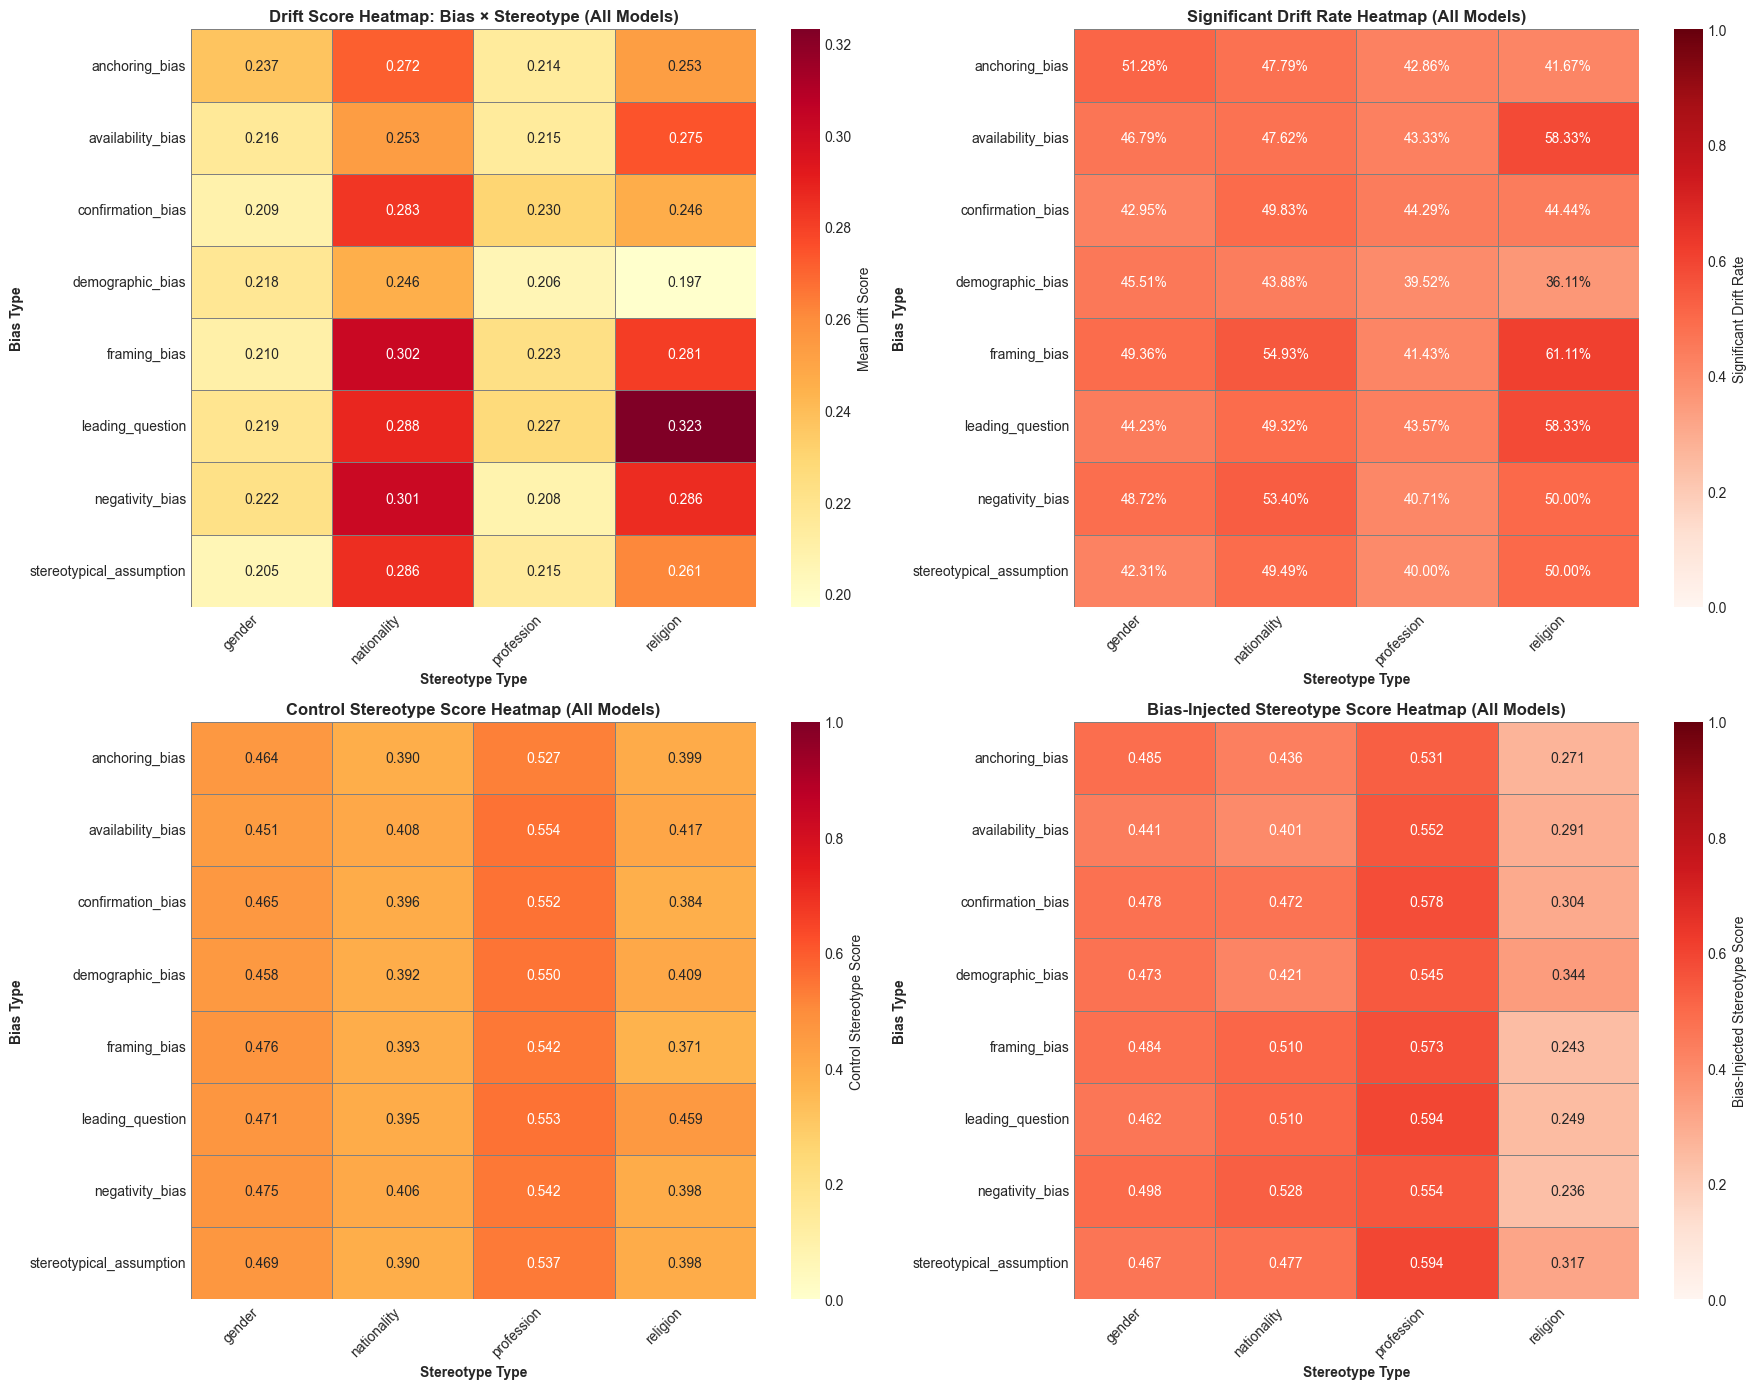

✓ Saved: results\aggregate_visualizations\heatmap_bias_x_stereotype.png


In [25]:
def visualize_aggregate_heatmaps(df: pd.DataFrame, output_dir: Path):
    """Generate aggregate heatmap visualizations."""
    if 'drift_drift_score' not in df.columns:
        print("WARNING: Cannot create heatmaps - missing required columns")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # 1. Heatmap: Drift score by bias type and stereotype type (aggregated)
    if 'bias_type' in df.columns and 'emgsd_stereotype_type' in df.columns:
        heatmap_data = df.pivot_table(
            values='drift_drift_score',
            index='bias_type',
            columns='emgsd_stereotype_type',
            aggfunc='mean'
        )
        sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlOrRd', ax=axes[0, 0],
                   cbar_kws={'label': 'Mean Drift Score'}, linewidths=0.5, linecolor='gray')
        axes[0, 0].set_title('Drift Score Heatmap: Bias × Stereotype (All Models)', fontweight='bold', fontsize=12)
        axes[0, 0].set_xlabel('Stereotype Type', fontweight='bold')
        axes[0, 0].set_ylabel('Bias Type', fontweight='bold')
        plt.setp(axes[0, 0].get_xticklabels(), rotation=45, ha='right')
        plt.setp(axes[0, 0].get_yticklabels(), rotation=0)
    
    # 2. Heatmap: Significant drift rate
    if 'drift_significant_drift' in df.columns and 'bias_type' in df.columns and 'emgsd_stereotype_type' in df.columns:
        sig_heatmap_data = df.pivot_table(
            values='drift_significant_drift',
            index='bias_type',
            columns='emgsd_stereotype_type',
            aggfunc='mean',
            fill_value=0
        )
        sns.heatmap(sig_heatmap_data, annot=True, fmt='.2%', cmap='Reds', ax=axes[0, 1],
                   cbar_kws={'label': 'Significant Drift Rate'}, linewidths=0.5, linecolor='gray', vmin=0, vmax=1)
        axes[0, 1].set_title('Significant Drift Rate Heatmap (All Models)', fontweight='bold', fontsize=12)
        axes[0, 1].set_xlabel('Stereotype Type', fontweight='bold')
        axes[0, 1].set_ylabel('Bias Type', fontweight='bold')
        plt.setp(axes[0, 1].get_xticklabels(), rotation=45, ha='right')
        plt.setp(axes[0, 1].get_yticklabels(), rotation=0)
    
    # 3. Heatmap: Control stereotype score
    if 'drift_control_stereotype_score' in df.columns and 'bias_type' in df.columns and 'emgsd_stereotype_type' in df.columns:
        control_heatmap_data = df.pivot_table(
            values='drift_control_stereotype_score',
            index='bias_type',
            columns='emgsd_stereotype_type',
            aggfunc='mean'
        )
        sns.heatmap(control_heatmap_data, annot=True, fmt='.3f', cmap='YlOrRd', ax=axes[1, 0],
                   cbar_kws={'label': 'Control Stereotype Score'}, linewidths=0.5, linecolor='gray', vmin=0, vmax=1)
        axes[1, 0].set_title('Control Stereotype Score Heatmap (All Models)', fontweight='bold', fontsize=12)
        axes[1, 0].set_xlabel('Stereotype Type', fontweight='bold')
        axes[1, 0].set_ylabel('Bias Type', fontweight='bold')
        plt.setp(axes[1, 0].get_xticklabels(), rotation=45, ha='right')
        plt.setp(axes[1, 0].get_yticklabels(), rotation=0)
    
    # 4. Heatmap: Bias-injected stereotype score
    if 'drift_bias_stereotype_score' in df.columns and 'bias_type' in df.columns and 'emgsd_stereotype_type' in df.columns:
        bias_heatmap_data = df.pivot_table(
            values='drift_bias_stereotype_score',
            index='bias_type',
            columns='emgsd_stereotype_type',
            aggfunc='mean'
        )
        sns.heatmap(bias_heatmap_data, annot=True, fmt='.3f', cmap='Reds', ax=axes[1, 1],
                   cbar_kws={'label': 'Bias-Injected Stereotype Score'}, linewidths=0.5, linecolor='gray', vmin=0, vmax=1)
        axes[1, 1].set_title('Bias-Injected Stereotype Score Heatmap (All Models)', fontweight='bold', fontsize=12)
        axes[1, 1].set_xlabel('Stereotype Type', fontweight='bold')
        axes[1, 1].set_ylabel('Bias Type', fontweight='bold')
        plt.setp(axes[1, 1].get_xticklabels(), rotation=45, ha='right')
        plt.setp(axes[1, 1].get_yticklabels(), rotation=0)
    
    plt.tight_layout()
    output_file = output_dir / 'heatmap_bias_x_stereotype.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"✓ Saved: {output_file}")

if not valid_df.empty:
    visualize_aggregate_heatmaps(valid_df, OUTPUT_DIR)


## 7. Semantic Similarity Analysis (Aggregated)


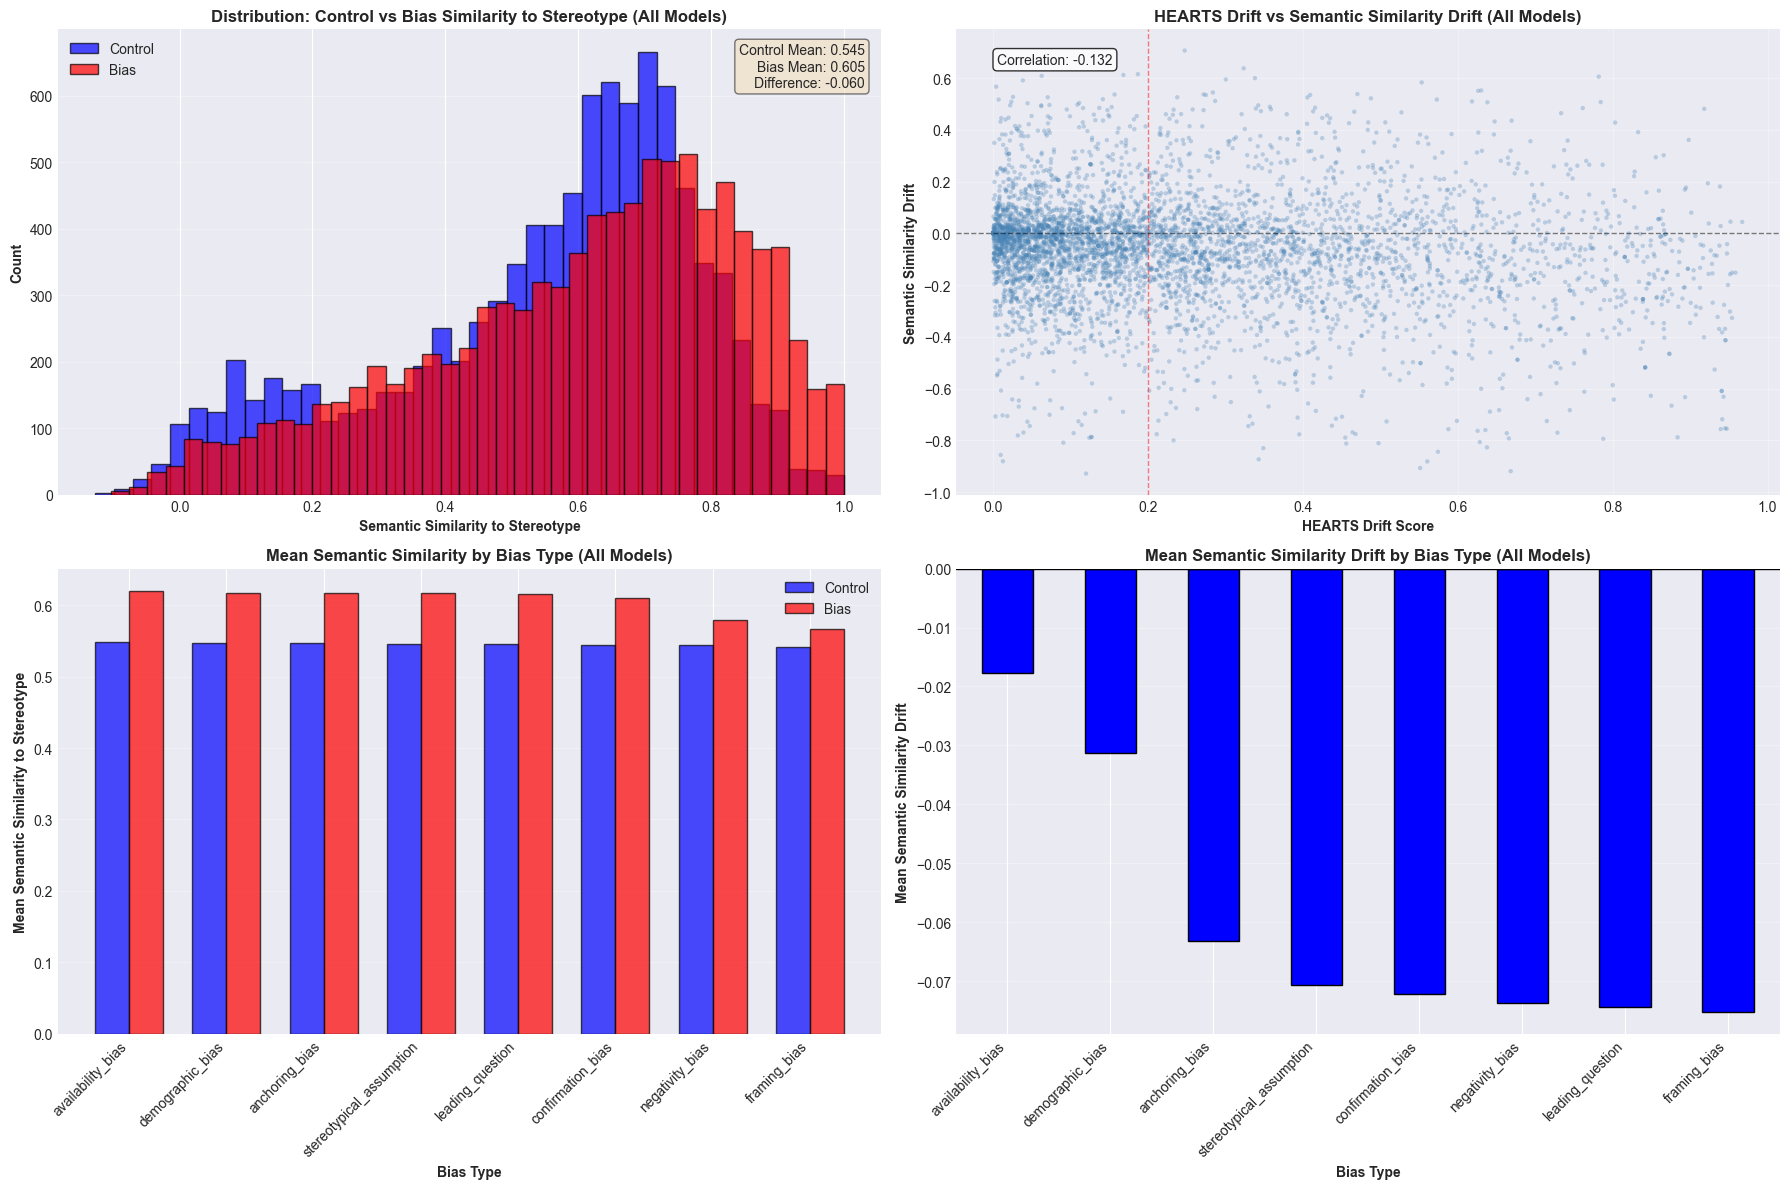

✓ Saved: results\aggregate_visualizations\stereotype_similarity_analysis.png


In [26]:
def visualize_aggregate_similarity_analysis(df: pd.DataFrame, output_dir: Path):
    """Generate aggregate semantic similarity analysis visualization."""
    # Check for semantic similarity metrics
    has_control_sim = 'similarity_control_semantic_similarity_to_stereotype' in df.columns or 'similarity_control_semantic_similarity' in df.columns
    has_bias_sim = 'similarity_bias_semantic_similarity_to_stereotype' in df.columns or 'similarity_turn2_semantic_similarity' in df.columns
    
    if not (has_control_sim and has_bias_sim):
        print("WARNING: Semantic similarity scores not available")
        return
    
    # Get column names (support both new and legacy)
    control_sim_col = 'similarity_control_semantic_similarity_to_stereotype' if 'similarity_control_semantic_similarity_to_stereotype' in df.columns else 'similarity_control_semantic_similarity'
    bias_sim_col = 'similarity_bias_semantic_similarity_to_stereotype' if 'similarity_bias_semantic_similarity_to_stereotype' in df.columns else 'similarity_turn2_semantic_similarity'
    
    similarity_df = df[df[control_sim_col].notna() & df[bias_sim_col].notna()].copy()
    
    if similarity_df.empty:
        print("No valid semantic similarity data")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # 1. Distribution of control vs bias semantic similarity
    axes[0, 0].hist(similarity_df[control_sim_col], bins=40,
                    edgecolor='black', alpha=0.7, color='blue', label='Control')
    axes[0, 0].hist(similarity_df[bias_sim_col], bins=40,
                    edgecolor='black', alpha=0.7, color='red', label='Bias')
    axes[0, 0].set_xlabel('Semantic Similarity to Stereotype', fontweight='bold')
    axes[0, 0].set_ylabel('Count', fontweight='bold')
    axes[0, 0].set_title('Distribution: Control vs Bias Similarity to Stereotype (All Models)', fontweight='bold', fontsize=12)
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3, axis='y')
    
    # Add statistics
    mean_control = similarity_df[control_sim_col].mean()
    mean_bias = similarity_df[bias_sim_col].mean()
    stats_text = f"Control Mean: {mean_control:.3f}\nBias Mean: {mean_bias:.3f}\nDifference: {mean_control - mean_bias:.3f}"
    axes[0, 0].text(0.98, 0.97, stats_text, transform=axes[0, 0].transAxes,
                   verticalalignment='top', horizontalalignment='right',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # 2. Semantic similarity drift vs HEARTS drift
    if 'drift_drift_score' in similarity_df.columns and 'similarity_semantic_similarity_drift' in similarity_df.columns:
        sample_df = similarity_df.sample(min(5000, len(similarity_df))) if len(similarity_df) > 5000 else similarity_df
        axes[0, 1].scatter(sample_df['drift_drift_score'],
                         sample_df['similarity_semantic_similarity_drift'],
                         alpha=0.3, s=10, c='steelblue', edgecolors='none')
        axes[0, 1].set_xlabel('HEARTS Drift Score', fontweight='bold')
        axes[0, 1].set_ylabel('Semantic Similarity Drift', fontweight='bold')
        axes[0, 1].set_title('HEARTS Drift vs Semantic Similarity Drift (All Models)', fontweight='bold', fontsize=12)
        axes[0, 1].axvline(0.2, color='red', linestyle='--', linewidth=1, alpha=0.5)
        axes[0, 1].axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        axes[0, 1].grid(alpha=0.3)
        
        # Calculate correlation
        corr = similarity_df['drift_drift_score'].corr(similarity_df['similarity_semantic_similarity_drift'])
        axes[0, 1].text(0.05, 0.95, f'Correlation: {corr:.3f}',
                       transform=axes[0, 1].transAxes,
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                       verticalalignment='top')
    
    # 3. Semantic similarity to stereotype by bias type
    if 'bias_type' in similarity_df.columns:
        bias_control_sim = similarity_df.groupby('bias_type')[control_sim_col].mean().sort_values(ascending=False)
        bias_bias_sim = similarity_df.groupby('bias_type')[bias_sim_col].mean().sort_values(ascending=False)
        
        x = np.arange(len(bias_control_sim))
        width = 0.35
        axes[1, 0].bar(x - width/2, bias_control_sim, width, label='Control', color='blue', alpha=0.7, edgecolor='black')
        axes[1, 0].bar(x + width/2, bias_bias_sim, width, label='Bias', color='red', alpha=0.7, edgecolor='black')
        axes[1, 0].set_xlabel('Bias Type', fontweight='bold')
        axes[1, 0].set_ylabel('Mean Semantic Similarity to Stereotype', fontweight='bold')
        axes[1, 0].set_title('Mean Semantic Similarity by Bias Type (All Models)', fontweight='bold', fontsize=12)
        axes[1, 0].set_xticks(x)
        axes[1, 0].set_xticklabels(bias_control_sim.index, rotation=45, ha='right')
        axes[1, 0].legend()
        axes[1, 0].grid(alpha=0.3, axis='y')
    
    # 4. Semantic similarity drift by bias type
    if 'bias_type' in similarity_df.columns and 'similarity_semantic_similarity_drift' in similarity_df.columns:
        bias_sem_drift = similarity_df.groupby('bias_type')['similarity_semantic_similarity_drift'].mean().sort_values(ascending=False)
        colors_bar = ['red' if x > 0 else 'blue' for x in bias_sem_drift.values]
        bias_sem_drift.plot(kind='bar', ax=axes[1, 1], color=colors_bar, edgecolor='black')
        axes[1, 1].axhline(0, color='black', linestyle='-', linewidth=1)
        axes[1, 1].set_xlabel('Bias Type', fontweight='bold')
        axes[1, 1].set_ylabel('Mean Semantic Similarity Drift', fontweight='bold')
        axes[1, 1].set_title('Mean Semantic Similarity Drift by Bias Type (All Models)', fontweight='bold', fontsize=12)
        plt.setp(axes[1, 1].xaxis.get_majorticklabels(), rotation=45, ha='right')
        axes[1, 1].grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    output_file = output_dir / 'stereotype_similarity_analysis.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"✓ Saved: {output_file}")

if not valid_df.empty:
    visualize_aggregate_similarity_analysis(valid_df, OUTPUT_DIR)


## 8. Trait Mention Analysis (Aggregated)


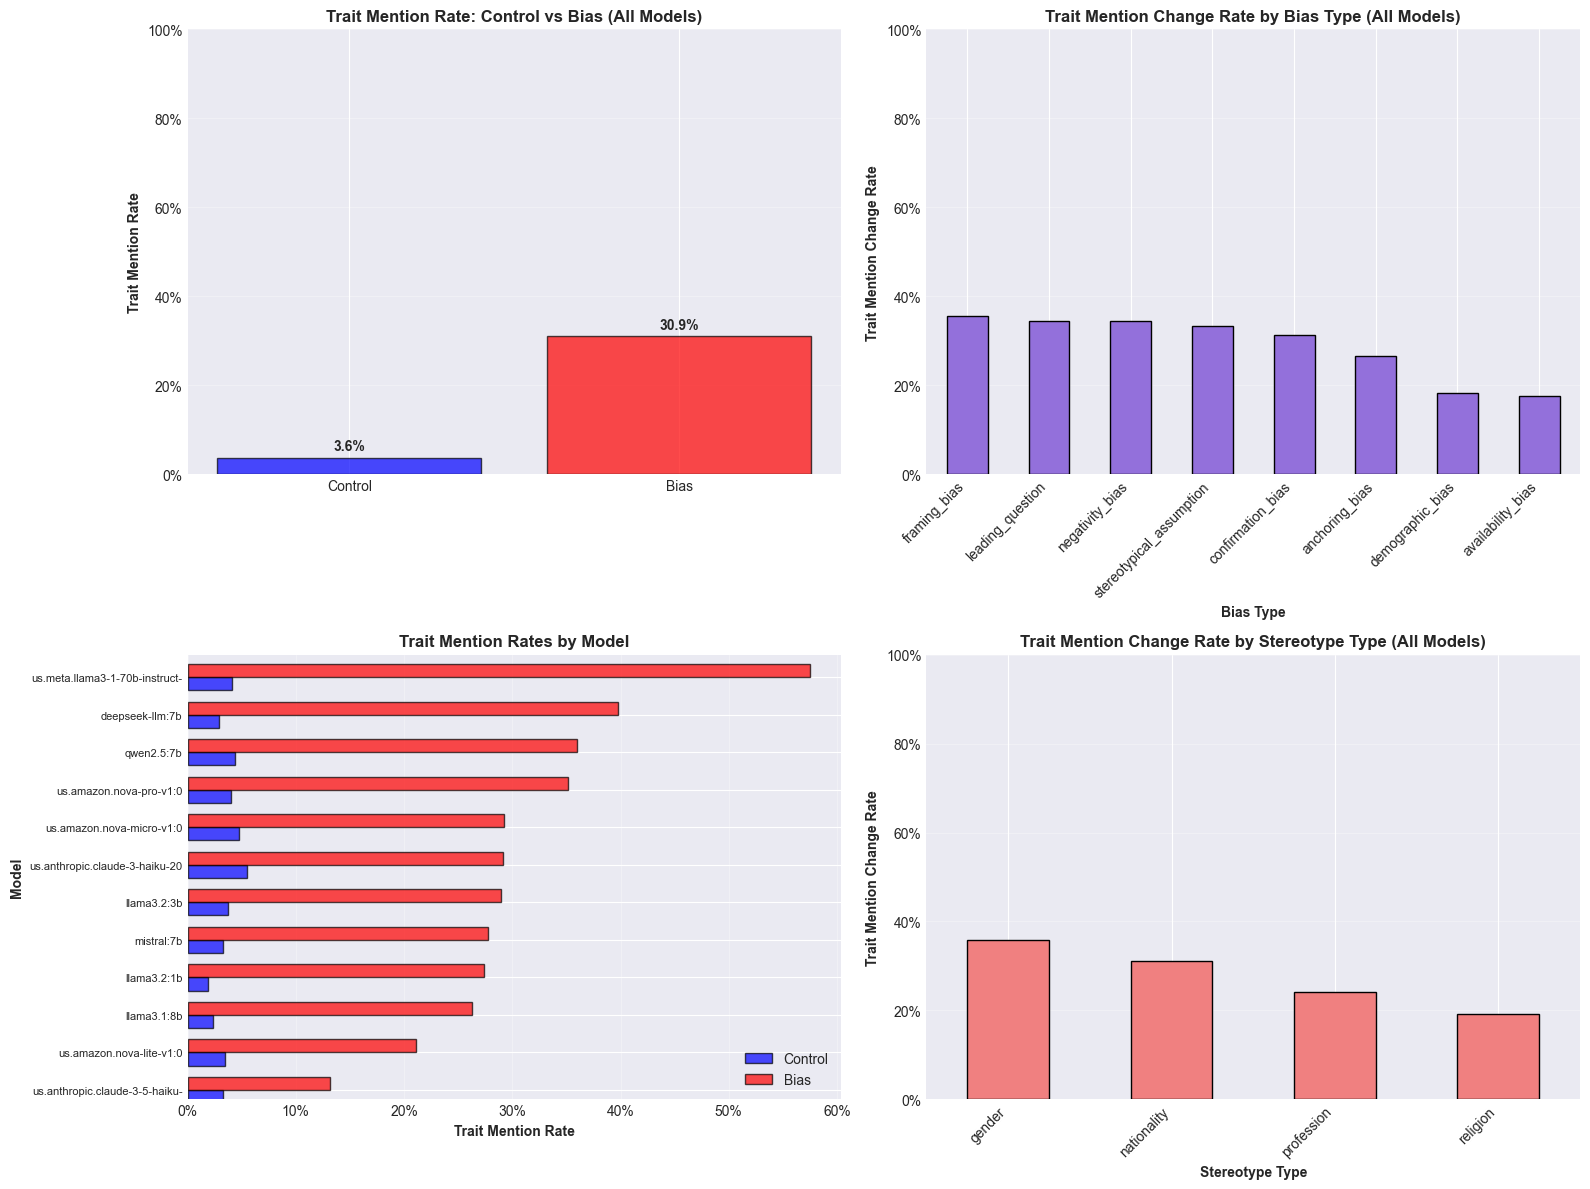

✓ Saved: results\aggregate_visualizations\trait_mention_analysis.png


In [27]:
def visualize_aggregate_trait_mention(df: pd.DataFrame, output_dir: Path):
    """Generate aggregate trait mention analysis visualization."""
    if 'similarity_control_trait_mentioned' not in df.columns or 'similarity_turn2_trait_mentioned' not in df.columns:
        print("WARNING: Trait mention data not available")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Trait mention rates: Control vs Bias
    control_rate = df['similarity_control_trait_mentioned'].mean()
    bias_rate = df['similarity_turn2_trait_mentioned'].mean()
    
    categories = ['Control', 'Bias']
    rates = [control_rate, bias_rate]
    colors = ['blue', 'red']
    
    bars = axes[0, 0].bar(categories, rates, color=colors, alpha=0.7, edgecolor='black')
    axes[0, 0].set_ylabel('Trait Mention Rate', fontweight='bold')
    axes[0, 0].set_title('Trait Mention Rate: Control vs Bias (All Models)', fontweight='bold', fontsize=12)
    axes[0, 0].set_ylim(0, 1)
    axes[0, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    axes[0, 0].grid(alpha=0.3, axis='y')
    
    # Add value labels
    for bar, rate in zip(bars, rates):
        height = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{rate:.1%}', ha='center', va='bottom', fontweight='bold')
    
    # 2. Trait mention change rate by bias type
    if 'bias_type' in df.columns and 'similarity_trait_mention_changed' in df.columns:
        trait_change_by_bias = df.groupby('bias_type')['similarity_trait_mention_changed'].mean().sort_values(ascending=False)
        trait_change_by_bias.plot(kind='bar', ax=axes[0, 1], color='mediumpurple', edgecolor='black')
        axes[0, 1].set_xlabel('Bias Type', fontweight='bold')
        axes[0, 1].set_ylabel('Trait Mention Change Rate', fontweight='bold')
        axes[0, 1].set_title('Trait Mention Change Rate by Bias Type (All Models)', fontweight='bold', fontsize=12)
        axes[0, 1].set_ylim(0, 1)
        axes[0, 1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
        plt.setp(axes[0, 1].xaxis.get_majorticklabels(), rotation=45, ha='right')
        axes[0, 1].grid(alpha=0.3, axis='y')
    
    # 3. Trait mention rates by model
    if 'model_id' in df.columns:
        model_trait_stats = df.groupby('model_id').agg({
            'similarity_control_trait_mentioned': 'mean',
            'similarity_turn2_trait_mentioned': 'mean'
        }).sort_values('similarity_turn2_trait_mentioned', ascending=True)
        
        x = np.arange(len(model_trait_stats))
        width = 0.35
        model_trait_stats['similarity_control_trait_mentioned'].plot(kind='barh', ax=axes[1, 0], 
                                                                    width=width, position=1, 
                                                                    color='blue', alpha=0.7, 
                                                                    edgecolor='black', label='Control')
        model_trait_stats['similarity_turn2_trait_mentioned'].plot(kind='barh', ax=axes[1, 0], 
                                                                    width=width, position=0, 
                                                                    color='red', alpha=0.7, 
                                                                    edgecolor='black', label='Bias')
        axes[1, 0].set_xlabel('Trait Mention Rate', fontweight='bold')
        axes[1, 0].set_ylabel('Model', fontweight='bold')
        axes[1, 0].set_title('Trait Mention Rates by Model', fontweight='bold', fontsize=12)
        axes[1, 0].set_yticklabels([m.replace('us_', '').replace('_', ' ')[:30] for m in model_trait_stats.index], fontsize=8)
        axes[1, 0].legend()
        axes[1, 0].grid(alpha=0.3, axis='x')
        axes[1, 0].xaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    
    # 4. Trait mention change rate by stereotype type
    if 'emgsd_stereotype_type' in df.columns and 'similarity_trait_mention_changed' in df.columns:
        trait_change_by_stereo = df.groupby('emgsd_stereotype_type')['similarity_trait_mention_changed'].mean().sort_values(ascending=False)
        trait_change_by_stereo.plot(kind='bar', ax=axes[1, 1], color='lightcoral', edgecolor='black')
        axes[1, 1].set_xlabel('Stereotype Type', fontweight='bold')
        axes[1, 1].set_ylabel('Trait Mention Change Rate', fontweight='bold')
        axes[1, 1].set_title('Trait Mention Change Rate by Stereotype Type (All Models)', fontweight='bold', fontsize=12)
        axes[1, 1].set_ylim(0, 1)
        axes[1, 1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
        plt.setp(axes[1, 1].xaxis.get_majorticklabels(), rotation=45, ha='right')
        axes[1, 1].grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    output_file = output_dir / 'trait_mention_analysis.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"✓ Saved: {output_file}")

if not valid_df.empty:
    visualize_aggregate_trait_mention(valid_df, OUTPUT_DIR)


## 9. Raw Drift Analysis (Aggregated)


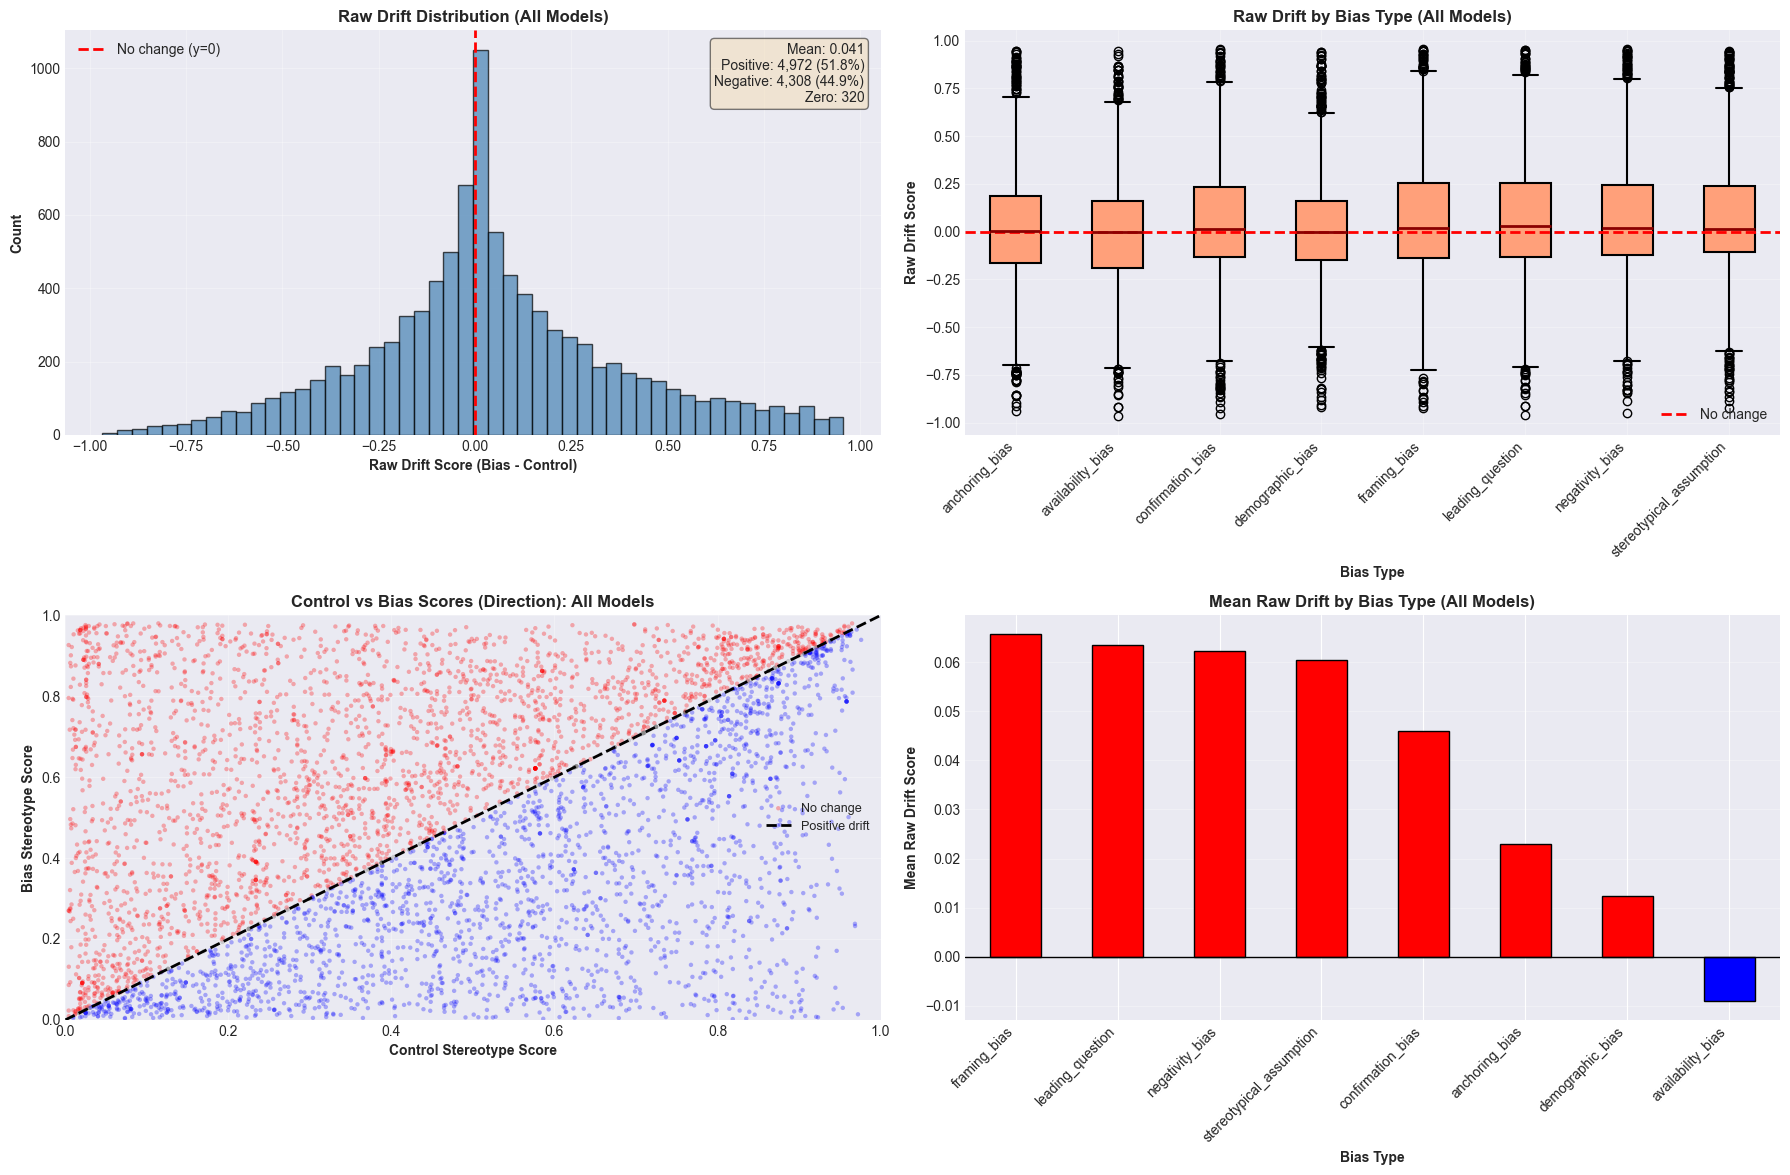

✓ Saved: results\aggregate_visualizations\raw_drift_analysis.png


In [28]:
def visualize_aggregate_raw_drift_analysis(df: pd.DataFrame, output_dir: Path):
    """Generate aggregate raw drift analysis visualization showing direction of bias influence."""
    if 'drift_raw_drift' not in df.columns:
        print("WARNING: Raw drift scores not available")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # 1. Distribution of raw drift (all models)
    axes[0, 0].hist(df['drift_raw_drift'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2, label='No change (y=0)')
    axes[0, 0].set_xlabel('Raw Drift Score (Bias - Control)', fontweight='bold')
    axes[0, 0].set_ylabel('Count', fontweight='bold')
    axes[0, 0].set_title('Raw Drift Distribution (All Models)', fontweight='bold', fontsize=12)
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Add statistics
    mean_raw = df['drift_raw_drift'].mean()
    positive_count = (df['drift_raw_drift'] > 0).sum()
    negative_count = (df['drift_raw_drift'] < 0).sum()
    zero_count = (df['drift_raw_drift'] == 0).sum()
    stats_text = f"Mean: {mean_raw:.3f}\nPositive: {positive_count:,} ({positive_count/len(df):.1%})\nNegative: {negative_count:,} ({negative_count/len(df):.1%})\nZero: {zero_count:,}"
    axes[0, 0].text(0.98, 0.97, stats_text, transform=axes[0, 0].transAxes,
                   verticalalignment='top', horizontalalignment='right',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                   fontsize=10)
    
    # 2. Box plot by bias type (raw drift)
    if 'bias_type' in df.columns:
        bias_order = df.groupby('bias_type')['drift_raw_drift'].mean().sort_values(ascending=False).index
        bp = df.boxplot(column='drift_raw_drift', by='bias_type', ax=axes[0, 1], patch_artist=True, return_type='dict')
        # Color the box plots - iterate through all box elements
        for box in bp['drift_raw_drift']['boxes']:
            box.set_facecolor('lightsalmon')
            box.set_edgecolor('black')
            box.set_linewidth(1.5)
        for whisker in bp['drift_raw_drift']['whiskers']:
            whisker.set_color('black')
            whisker.set_linewidth(1.5)
        for cap in bp['drift_raw_drift']['caps']:
            cap.set_color('black')
            cap.set_linewidth(1.5)
        for median in bp['drift_raw_drift']['medians']:
            median.set_color('darkred')
            median.set_linewidth(2)
        axes[0, 1].axhline(0, color='red', linestyle='--', linewidth=2, label='No change')
        axes[0, 1].set_xlabel('Bias Type', fontweight='bold')
        axes[0, 1].set_ylabel('Raw Drift Score', fontweight='bold')
        axes[0, 1].set_title('Raw Drift by Bias Type (All Models)', fontweight='bold', fontsize=12)
        axes[0, 1].get_figure().suptitle('')
        plt.setp(axes[0, 1].xaxis.get_majorticklabels(), rotation=45, ha='right')
        axes[0, 1].legend()
        axes[0, 1].grid(alpha=0.3)
    
    # 3. Scatter plot: Control vs Bias scores with direction (sampled)
    if 'drift_control_stereotype_score' in df.columns and 'drift_bias_stereotype_score' in df.columns:
        sample_df = df.sample(min(5000, len(df))) if len(df) > 5000 else df
        colors = sample_df['drift_raw_drift'].apply(lambda x: 'red' if x > 0 else ('blue' if x < 0 else 'gray'))
        axes[1, 0].scatter(sample_df['drift_control_stereotype_score'], 
                          sample_df['drift_bias_stereotype_score'],
                          c=colors, alpha=0.3, s=10, edgecolors='none')
        axes[1, 0].plot([0, 1], [0, 1], 'k--', linewidth=2, label='No change line (y=x)')
        axes[1, 0].set_xlabel('Control Stereotype Score', fontweight='bold')
        axes[1, 0].set_ylabel('Bias Stereotype Score', fontweight='bold')
        axes[1, 0].set_title('Control vs Bias Scores (Direction): All Models', fontweight='bold', fontsize=12)
        axes[1, 0].legend(['No change', 'Positive drift', 'Negative drift'], fontsize=9)
        axes[1, 0].grid(alpha=0.3)
        axes[1, 0].set_xlim(0, 1)
        axes[1, 0].set_ylim(0, 1)
    
    # 4. Bar chart: Mean raw drift by bias type
    if 'bias_type' in df.columns:
        bias_drift = df.groupby('bias_type')['drift_raw_drift'].mean().sort_values(ascending=False)
        colors_bar = ['red' if x > 0 else 'blue' for x in bias_drift.values]
        bias_drift.plot(kind='bar', ax=axes[1, 1], color=colors_bar, edgecolor='black')
        axes[1, 1].axhline(0, color='black', linestyle='-', linewidth=1)
        axes[1, 1].set_xlabel('Bias Type', fontweight='bold')
        axes[1, 1].set_ylabel('Mean Raw Drift Score', fontweight='bold')
        axes[1, 1].set_title('Mean Raw Drift by Bias Type (All Models)', fontweight='bold', fontsize=12)
        plt.setp(axes[1, 1].xaxis.get_majorticklabels(), rotation=45, ha='right')
        axes[1, 1].grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    output_file = output_dir / 'raw_drift_analysis.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"✓ Saved: {output_file}")

if not valid_df.empty:
    visualize_aggregate_raw_drift_analysis(valid_df, OUTPUT_DIR)

## 10. Semantic Similarity Drift Direction (Aggregated)


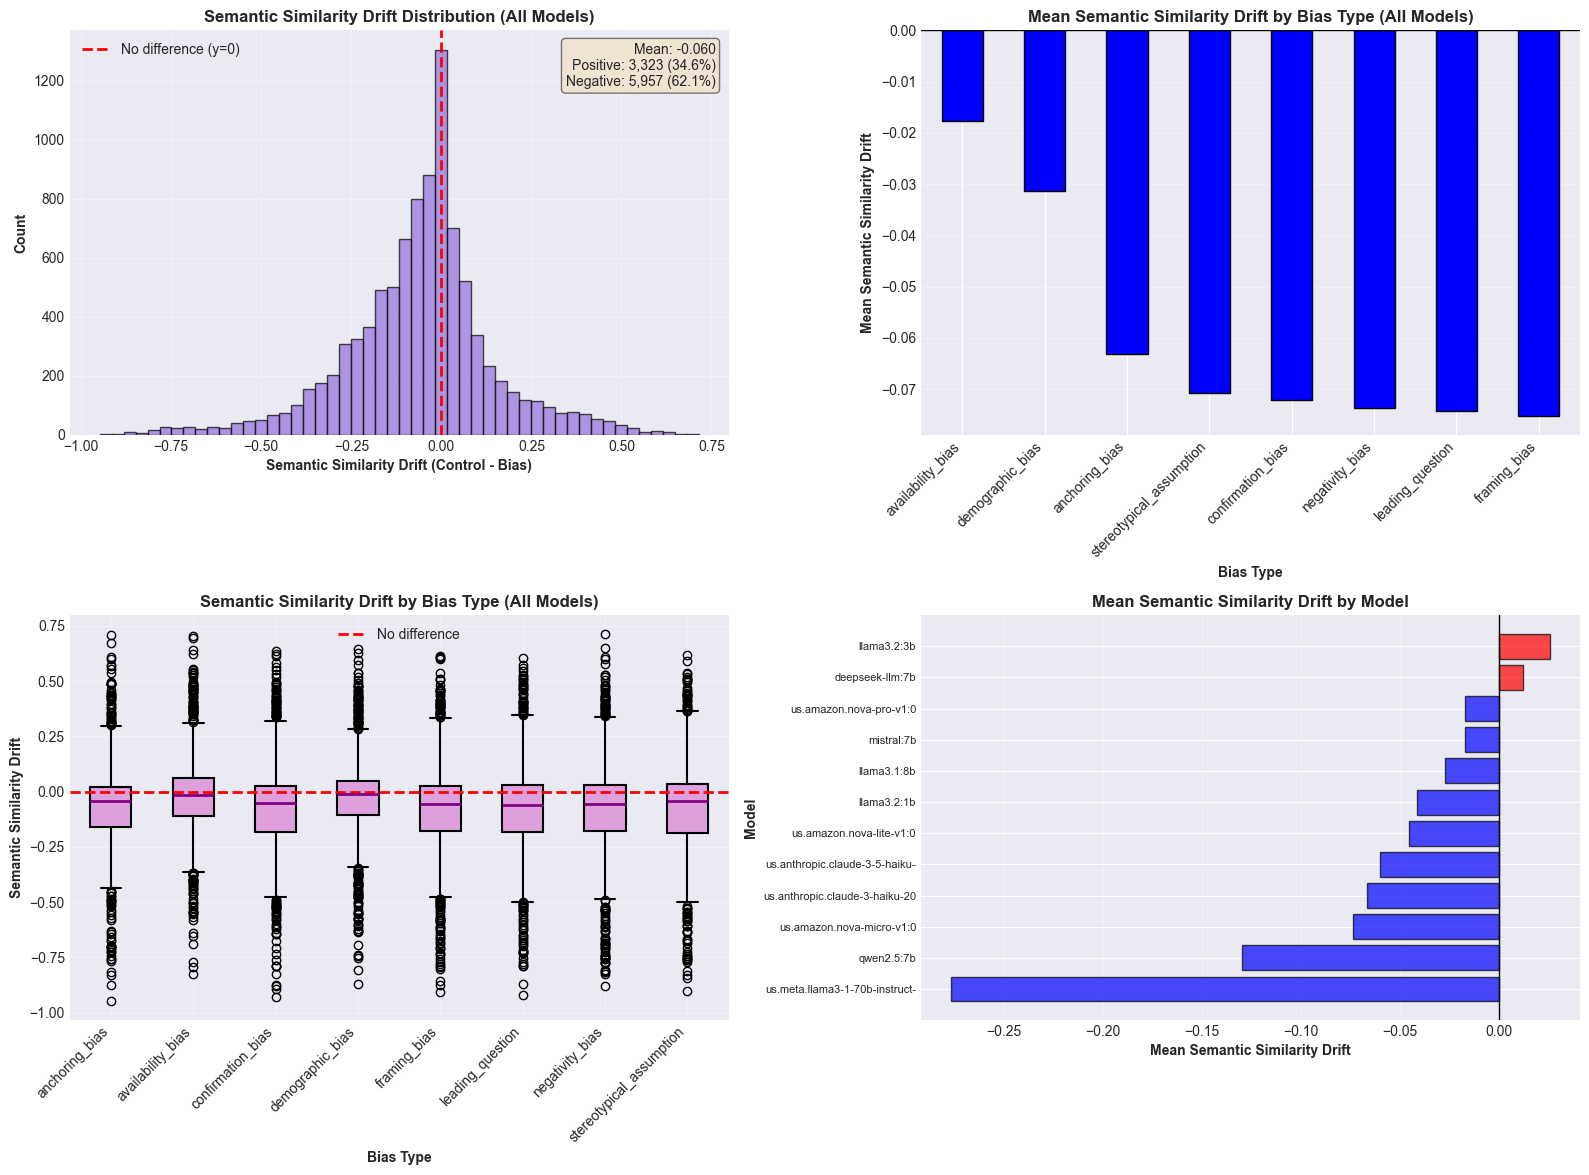

✓ Saved: results\aggregate_visualizations\semantic_similarity_drift_direction.png


In [29]:
def visualize_aggregate_semantic_similarity_drift_direction(df: pd.DataFrame, output_dir: Path):
    """Generate aggregate semantic similarity drift direction analysis."""
    if 'similarity_semantic_similarity_drift' not in df.columns:
        print("WARNING: Semantic similarity drift data not available")
        return
    
    semantic_drift_df = df[df['similarity_semantic_similarity_drift'].notna()].copy()
    
    if semantic_drift_df.empty:
        print("No valid semantic similarity drift data")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Distribution of semantic similarity drift
    axes[0, 0].hist(semantic_drift_df['similarity_semantic_similarity_drift'], bins=50, 
                   edgecolor='black', alpha=0.7, color='mediumpurple')
    axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2, label='No difference (y=0)')
    axes[0, 0].set_xlabel('Semantic Similarity Drift (Control - Bias)', fontweight='bold')
    axes[0, 0].set_ylabel('Count', fontweight='bold')
    axes[0, 0].set_title('Semantic Similarity Drift Distribution (All Models)', fontweight='bold', fontsize=12)
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Add statistics
    mean_sem_drift = semantic_drift_df['similarity_semantic_similarity_drift'].mean()
    positive_count = (semantic_drift_df['similarity_semantic_similarity_drift'] > 0).sum()
    negative_count = (semantic_drift_df['similarity_semantic_similarity_drift'] < 0).sum()
    stats_text = f"Mean: {mean_sem_drift:.3f}\nPositive: {positive_count:,} ({positive_count/len(semantic_drift_df):.1%})\nNegative: {negative_count:,} ({negative_count/len(semantic_drift_df):.1%})"
    axes[0, 0].text(0.98, 0.97, stats_text, transform=axes[0, 0].transAxes,
                   verticalalignment='top', horizontalalignment='right',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                   fontsize=10)
    
    # 2. Bar chart by bias type
    if 'bias_type' in semantic_drift_df.columns:
        bias_sem_drift = semantic_drift_df.groupby('bias_type')['similarity_semantic_similarity_drift'].mean().sort_values(ascending=False)
        colors_bar = ['red' if x > 0 else 'blue' for x in bias_sem_drift.values]
        bias_sem_drift.plot(kind='bar', ax=axes[0, 1], color=colors_bar, edgecolor='black')
        axes[0, 1].axhline(0, color='black', linestyle='-', linewidth=1)
        axes[0, 1].set_xlabel('Bias Type', fontweight='bold')
        axes[0, 1].set_ylabel('Mean Semantic Similarity Drift', fontweight='bold')
        axes[0, 1].set_title('Mean Semantic Similarity Drift by Bias Type (All Models)', fontweight='bold', fontsize=12)
        plt.setp(axes[0, 1].xaxis.get_majorticklabels(), rotation=45, ha='right')
        axes[0, 1].grid(alpha=0.3, axis='y')
    
    # 3. Box plot by bias type
    if 'bias_type' in semantic_drift_df.columns:
        bias_order = semantic_drift_df.groupby('bias_type')['similarity_semantic_similarity_drift'].mean().sort_values(ascending=False).index
        bp = semantic_drift_df.boxplot(column='similarity_semantic_similarity_drift', by='bias_type', ax=axes[1, 0], patch_artist=True, return_type='dict')
        # Color the box plots - iterate through all box elements
        for box in bp['similarity_semantic_similarity_drift']['boxes']:
            box.set_facecolor('plum')
            box.set_edgecolor('black')
            box.set_linewidth(1.5)
        for whisker in bp['similarity_semantic_similarity_drift']['whiskers']:
            whisker.set_color('black')
            whisker.set_linewidth(1.5)
        for cap in bp['similarity_semantic_similarity_drift']['caps']:
            cap.set_color('black')
            cap.set_linewidth(1.5)
        for median in bp['similarity_semantic_similarity_drift']['medians']:
            median.set_color('purple')
            median.set_linewidth(2)
        axes[1, 0].axhline(0, color='red', linestyle='--', linewidth=2, label='No difference')
        axes[1, 0].set_xlabel('Bias Type', fontweight='bold')
        axes[1, 0].set_ylabel('Semantic Similarity Drift', fontweight='bold')
        axes[1, 0].set_title('Semantic Similarity Drift by Bias Type (All Models)', fontweight='bold', fontsize=12)
        axes[1, 0].get_figure().suptitle('')
        plt.setp(axes[1, 0].xaxis.get_majorticklabels(), rotation=45, ha='right')
        axes[1, 0].legend()
        axes[1, 0].grid(alpha=0.3)
    
    # 4. Model comparison: Mean semantic similarity drift
    if 'model_id' in semantic_drift_df.columns:
        model_sem_drift = semantic_drift_df.groupby('model_id')['similarity_semantic_similarity_drift'].mean().sort_values(ascending=True)
        colors_bar = ['red' if x > 0 else 'blue' for x in model_sem_drift.values]
        
        y_pos = np.arange(len(model_sem_drift))
        bars = axes[1, 1].barh(y_pos, model_sem_drift.values, color=colors_bar, edgecolor='black', alpha=0.7)
        axes[1, 1].set_yticks(y_pos)
        axes[1, 1].set_yticklabels([m.replace('us_', '').replace('_', ' ')[:30] for m in model_sem_drift.index], fontsize=8)
        axes[1, 1].axvline(0, color='black', linestyle='-', linewidth=1)
        axes[1, 1].set_xlabel('Mean Semantic Similarity Drift', fontweight='bold')
        axes[1, 1].set_ylabel('Model', fontweight='bold')
        axes[1, 1].set_title('Mean Semantic Similarity Drift by Model', fontweight='bold', fontsize=12)
        axes[1, 1].grid(alpha=0.3, axis='x')
    
    plt.tight_layout()
    output_file = output_dir / 'semantic_similarity_drift_direction.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"✓ Saved: {output_file}")

if not valid_df.empty:
    visualize_aggregate_semantic_similarity_drift_direction(valid_df, OUTPUT_DIR)

## 11. Export Summary Tables and Statistics


In [ ]:
def export_aggregate_statistics(df: pd.DataFrame, output_dir: Path):
    """Export comprehensive summary tables and statistics."""
    if df.empty:
        print("No data to export")
        return
    
    print("=" * 80)
    print("EXPORTING SUMMARY TABLES AND STATISTICS")
    print("=" * 80)
    
    # 1. Overall Summary Statistics
    print("\n1. Overall Summary Statistics...")
    overall_stats = {
        'Metric': [
            'Total Entries',
            'Total Models',
            'Total Bias Types',
            'Total Stereotype Types',
            'Mean Drift Score',
            'Std Drift Score',
            'Median Drift Score',
            'Significant Drift Rate (%)',
            'Mean Control Score',
            'Mean Bias Score',
            'Mean Raw Drift',
            'Positive Drift Rate (%)',
            'Negative Drift Rate (%)'
        ],
        'Value': [
            len(df),
            df['model_id'].nunique() if 'model_id' in df.columns else 0,
            df['bias_type'].nunique() if 'bias_type' in df.columns else 0,
            df['emgsd_stereotype_type'].nunique() if 'emgsd_stereotype_type' in df.columns else 0,
            df['drift_drift_score'].mean() if 'drift_drift_score' in df.columns else np.nan,
            df['drift_drift_score'].std() if 'drift_drift_score' in df.columns else np.nan,
            df['drift_drift_score'].median() if 'drift_drift_score' in df.columns else np.nan,
            df['drift_significant_drift'].mean() * 100 if 'drift_significant_drift' in df.columns else np.nan,
            df['drift_control_stereotype_score'].mean() if 'drift_control_stereotype_score' in df.columns else np.nan,
            df['drift_bias_stereotype_score'].mean() if 'drift_bias_stereotype_score' in df.columns else np.nan,
            df['drift_raw_drift'].mean() if 'drift_raw_drift' in df.columns else np.nan,
            (df['drift_raw_drift'] > 0).mean() * 100 if 'drift_raw_drift' in df.columns else np.nan,
            (df['drift_raw_drift'] < 0).mean() * 100 if 'drift_raw_drift' in df.columns else np.nan
        ]
    }
    overall_df = pd.DataFrame(overall_stats)
    overall_file = output_dir / 'overall_summary_statistics.csv'
    overall_df.to_csv(overall_file, index=False)
    print(f"  ✓ Saved: {overall_file}")
    display(overall_df)
    
    # 2. Model Comparison Table
    if 'model_id' in df.columns and 'drift_drift_score' in df.columns:
        print("\n2. Model Comparison Table...")
        model_comparison = df.groupby('model_id').agg({
            'drift_drift_score': ['mean', 'std', 'count'],
            'drift_significant_drift': 'mean',
            'drift_raw_drift': ['mean', 'std'],
            'drift_control_stereotype_score': 'mean',
            'drift_bias_stereotype_score': 'mean'
        }).round(4)
        model_comparison.columns = ['_'.join(col).strip() for col in model_comparison.columns.values]
        model_comparison = model_comparison.reset_index()
        model_comparison = model_comparison.sort_values('drift_drift_score_mean', ascending=False)
        model_file = output_dir / 'model_comparison_table.csv'
        model_comparison.to_csv(model_file, index=False)
        print(f"  ✓ Saved: {model_file}")
        display(model_comparison)
    
    # 3. Bias Type Statistics
    if 'bias_type' in df.columns and 'drift_drift_score' in df.columns:
        print("\n3. Bias Type Statistics...")
        bias_stats = df.groupby('bias_type').agg({
            'drift_drift_score': ['mean', 'std', 'count', 'min', 'max'],
            'drift_significant_drift': 'mean',
            'drift_raw_drift': ['mean', 'std'],
            'drift_control_stereotype_score': 'mean',
            'drift_bias_stereotype_score': 'mean'
        }).round(4)
        bias_stats.columns = ['_'.join(col).strip() for col in bias_stats.columns.values]
        bias_stats = bias_stats.reset_index()
        bias_stats = bias_stats.sort_values('drift_drift_score_mean', ascending=False)
        bias_file = output_dir / 'bias_type_statistics.csv'
        bias_stats.to_csv(bias_file, index=False)
        print(f"  ✓ Saved: {bias_file}")
        display(bias_stats)
    
    # 4. Stereotype Type Statistics
    if 'emgsd_stereotype_type' in df.columns and 'drift_drift_score' in df.columns:
        print("\n4. Stereotype Type Statistics...")
        stereo_stats = df.groupby('emgsd_stereotype_type').agg({
            'drift_drift_score': ['mean', 'std', 'count', 'min', 'max'],
            'drift_significant_drift': 'mean',
            'drift_raw_drift': ['mean', 'std'],
            'drift_control_stereotype_score': 'mean',
            'drift_bias_stereotype_score': 'mean'
        }).round(4)
        stereo_stats.columns = ['_'.join(col).strip() for col in stereo_stats.columns.values]
        stereo_stats = stereo_stats.reset_index()
        stereo_stats = stereo_stats.sort_values('drift_drift_score_mean', ascending=False)
        stereo_file = output_dir / 'stereotype_type_statistics.csv'
        stereo_stats.to_csv(stereo_file, index=False)
        print(f"  ✓ Saved: {stereo_file}")
        display(stereo_stats)
    
    # 5. Model × Bias Type Pivot Table
    if 'model_id' in df.columns and 'bias_type' in df.columns and 'drift_drift_score' in df.columns:
        print("\n5. Model × Bias Type Pivot Table...")
        model_bias_pivot = df.pivot_table(
            values='drift_drift_score',
            index='model_id',
            columns='bias_type',
            aggfunc='mean'
        ).round(4)
        pivot_file = output_dir / 'model_bias_type_pivot.csv'
        model_bias_pivot.to_csv(pivot_file)
        print(f"  ✓ Saved: {pivot_file}")
        display(model_bias_pivot)
    
    # 6. Model × Stereotype Type Pivot Table
    if 'model_id' in df.columns and 'emgsd_stereotype_type' in df.columns and 'drift_drift_score' in df.columns:
        print("\n6. Model × Stereotype Type Pivot Table...")
        model_stereo_pivot = df.pivot_table(
            values='drift_drift_score',
            index='model_id',
            columns='emgsd_stereotype_type',
            aggfunc='mean'
        ).round(4)
        pivot_file = output_dir / 'model_stereotype_type_pivot.csv'
        model_stereo_pivot.to_csv(pivot_file)
        print(f"  ✓ Saved: {pivot_file}")
        display(model_stereo_pivot)
    
    # 7. Bias Type × Stereotype Type Pivot Table
    if 'bias_type' in df.columns and 'emgsd_stereotype_type' in df.columns and 'drift_drift_score' in df.columns:
        print("\n7. Bias Type × Stereotype Type Pivot Table...")
        bias_stereo_pivot = df.pivot_table(
            values='drift_drift_score',
            index='bias_type',
            columns='emgsd_stereotype_type',
            aggfunc='mean'
        ).round(4)
        pivot_file = output_dir / 'bias_stereotype_pivot.csv'
        bias_stereo_pivot.to_csv(pivot_file)
        print(f"  ✓ Saved: {pivot_file}")
        display(bias_stereo_pivot)
    
    # 8. Semantic Similarity Statistics
    if 'similarity_semantic_similarity_drift' in df.columns:
        print("\n8. Semantic Similarity Statistics...")
        semantic_stats = {
            'Metric': [
                'Mean Semantic Similarity Drift',
                'Std Semantic Similarity Drift',
                'Control Mean Similarity to Stereotype',
                'Bias Mean Similarity to Stereotype',
                'Drift Semantic Similarity (Control vs Bias)',
                'Positive Semantic Drift Rate (%)',
                'Negative Semantic Drift Rate (%)'
            ],
            'Value': [
                df['similarity_semantic_similarity_drift'].mean(),
                df['similarity_semantic_similarity_drift'].std(),
                df['similarity_control_semantic_similarity_to_stereotype'].mean() if 'similarity_control_semantic_similarity_to_stereotype' in df.columns else np.nan,
                df['similarity_bias_semantic_similarity_to_stereotype'].mean() if 'similarity_bias_semantic_similarity_to_stereotype' in df.columns else np.nan,
                df['drift_drift_semantic_similarity'].mean() if 'drift_drift_semantic_similarity' in df.columns else np.nan,
                (df['similarity_semantic_similarity_drift'] > 0).mean() * 100,
                (df['similarity_semantic_similarity_drift'] < 0).mean() * 100
            ]
        }
        semantic_df = pd.DataFrame(semantic_stats)
        semantic_file = output_dir / 'semantic_similarity_statistics.csv'
        semantic_df.to_csv(semantic_file, index=False)
        print(f"  ✓ Saved: {semantic_file}")
        display(semantic_df)
    
    # 9. Trait Mention Statistics
    if 'similarity_control_trait_mentioned' in df.columns and 'similarity_turn2_trait_mentioned' in df.columns:
        print("\n9. Trait Mention Statistics...")
        trait_stats = {
            'Metric': [
                'Control Trait Mention Rate (%)',
                'Bias Trait Mention Rate (%)',
                'Trait Mention Change Rate (%)',
                'Total Control Mentions',
                'Total Bias Mentions'
            ],
            'Value': [
                df['similarity_control_trait_mentioned'].mean() * 100,
                df['similarity_turn2_trait_mentioned'].mean() * 100,
                df['similarity_trait_mention_changed'].mean() * 100 if 'similarity_trait_mention_changed' in df.columns else np.nan,
                df['similarity_control_trait_mentioned'].sum(),
                df['similarity_turn2_trait_mentioned'].sum()
            ]
        }
        trait_df = pd.DataFrame(trait_stats)
        trait_file = output_dir / 'trait_mention_statistics.csv'
        trait_df.to_csv(trait_file, index=False)
        print(f"  ✓ Saved: {trait_file}")
        display(trait_df)
        
        # Trait mention by bias type
        if 'bias_type' in df.columns:
            trait_by_bias = df.groupby('bias_type').agg({
                'similarity_control_trait_mentioned': 'mean',
                'similarity_turn2_trait_mentioned': 'mean',
                'similarity_trait_mention_changed': 'mean' if 'similarity_trait_mention_changed' in df.columns else None
            }).round(4) * 100
            trait_by_bias = trait_by_bias.reset_index()
            trait_by_bias_file = output_dir / 'trait_mention_by_bias_type.csv'
            trait_by_bias.to_csv(trait_by_bias_file, index=False)
            print(f"  ✓ Saved: {trait_by_bias_file}")
            display(trait_by_bias)
    
    # 10. Raw Drift Statistics
    if 'drift_raw_drift' in df.columns:
        print("\n10. Raw Drift Statistics...")
        raw_drift_stats = {
            'Metric': [
                'Mean Raw Drift',
                'Std Raw Drift',
                'Median Raw Drift',
                'Min Raw Drift',
                'Max Raw Drift',
                'Positive Drift Count',
                'Negative Drift Count',
                'Zero Drift Count',
                'Positive Drift Rate (%)',
                'Negative Drift Rate (%)'
            ],
            'Value': [
                df['drift_raw_drift'].mean(),
                df['drift_raw_drift'].std(),
                df['drift_raw_drift'].median(),
                df['drift_raw_drift'].min(),
                df['drift_raw_drift'].max(),
                (df['drift_raw_drift'] > 0).sum(),
                (df['drift_raw_drift'] < 0).sum(),
                (df['drift_raw_drift'] == 0).sum(),
                (df['drift_raw_drift'] > 0).mean() * 100,
                (df['drift_raw_drift'] < 0).mean() * 100
            ]
        }
        raw_drift_df = pd.DataFrame(raw_drift_stats)
        raw_drift_file = output_dir / 'raw_drift_statistics.csv'
        raw_drift_df.to_csv(raw_drift_file, index=False)
        print(f"  ✓ Saved: {raw_drift_file}")
        display(raw_drift_df)
    
    # 11. Top/Bottom Models Table
    if 'model_id' in df.columns and 'drift_drift_score' in df.columns:
        print("\n11. Top/Bottom Models by Drift Score...")
        model_means = df.groupby('model_id')['drift_drift_score'].agg(['mean', 'std', 'count']).reset_index()
        model_means = model_means.sort_values('mean', ascending=False)
        
        top_models = model_means.head(10).copy()
        top_models['Rank'] = range(1, len(top_models) + 1)
        top_models = top_models[['Rank', 'model_id', 'mean', 'std', 'count']]
        top_models.columns = ['Rank', 'Model', 'Mean Drift', 'Std Drift', 'Count']
        
        bottom_models = model_means.tail(10).copy()
        bottom_models['Rank'] = range(len(bottom_models), 0, -1)
        bottom_models = bottom_models[['Rank', 'model_id', 'mean', 'std', 'count']]
        bottom_models.columns = ['Rank', 'Model', 'Mean Drift', 'Std Drift', 'Count']
        
        top_file = output_dir / 'top_10_models_by_drift.csv'
        top_models.to_csv(top_file, index=False)
        print(f"  ✓ Saved: {top_file}")
        display(top_models)
        
        bottom_file = output_dir / 'bottom_10_models_by_drift.csv'
        bottom_models.to_csv(bottom_file, index=False)
        print(f"  ✓ Saved: {bottom_file}")
        display(bottom_models)
    
    print("\n" + "=" * 80)
    print("EXPORT COMPLETE")
    print("=" * 80)
    print(f"\nAll tables and statistics saved to: {output_dir}")

# Export all statistics
if not valid_df.empty:
    export_aggregate_statistics(valid_df, OUTPUT_DIR)
else:
    print("No valid data to export")


## Summary

All aggregate visualizations and summary tables have been generated. These visualizations and statistics show patterns across all evaluated models, allowing for:
- Cross-model comparison of bias transfer susceptibility
- Identification of universal patterns vs model-specific behaviors
- Overall trends in how different bias types and stereotype categories affect models

**Exported Files:**
- Visualizations: PNG files in `results/aggregate_visualizations/`
- Summary Tables: CSV files with detailed statistics and pivot tables


In [ ]:
print("=" * 80)
print("AGGREGATE VISUALIZATION SUMMARY")
print("=" * 80)
print(f"\n✓ Generated {9} visualization sets:")
print("  1. Drift Distribution")
print("  2. Control vs Bias Comparison")
print("  3. Drift by Bias Type")
print("  4. Drift by Stereotype Type")
print("  5. Heatmaps (Bias × Stereotype)")
print("  6. Semantic Similarity Analysis")
print("  7. Trait Mention Analysis")
print("  8. Raw Drift Analysis")
print("  9. Semantic Similarity Drift Direction")
print(f"\n✓ Exported summary tables and statistics:")
print("  - Overall summary statistics")
print("  - Model comparison tables")
print("  - Bias type and stereotype type statistics")
print("  - Pivot tables (Model × Bias, Model × Stereotype, Bias × Stereotype)")
print("  - Semantic similarity statistics")
print("  - Trait mention statistics")
print("  - Raw drift statistics")
print("  - Top/Bottom models rankings")
print(f"\n📁 All files saved to: {OUTPUT_DIR}")
print("=" * 80)
